# 1) Single Layer LSTM

In [1]:
# Importing required libraries
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import tensorflow as tf
import datetime as datetime
from datetime import timedelta
from tqdm import tqdm
sns.set()
tf.compat.v1.random.set_random_seed(1234)
import sys

### The libraries are imported for basic mathematical operations, data manipulations and visualization purpose. Randome seeds are set to tf version 1 for reproducibility purpose. tqdm module is imported to get fast and extensible progress bar of loops and functions. The timedelta module represents the difference between 2 dates or times. yfinance API is used to get the historical data of stock.

In [63]:
# Loading the data using yf
start_date = datetime.datetime(2023, 1, 20)
end_date = datetime.datetime(2024, 2, 5)

ticker_symbol = 'SBIN.NS'

data = yf.download(ticker_symbol, start=start_date, end=end_date)
data = data.reset_index()
data.head()

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2023-01-20,593.799988,596.599976,590.799988,592.200012,580.911438,6750607
1,2023-01-23,598.500000,601.750000,592.950012,600.450012,589.004150,6604469
2,2023-01-24,603.500000,604.599976,593.049988,594.349976,583.020386,7609623
3,2023-01-25,595.849976,595.849976,567.400024,568.700012,557.859375,25686294
4,2023-01-27,568.000000,568.549988,532.250000,539.950012,529.657410,40163464


### The historical data of SBIN stock is downloaded from yfinance API.

In [87]:
# Scaling the data using minmax scaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler().fit(data.iloc[:, 4:5].astype('float32'))
df = scaler.transform(data.iloc[:, 4:5].astype('float32'))
df = pd.DataFrame(df)
df.head()

,0
0,0.578807
1,0.633789
2,0.593135
3,0.422193
4,0.230590


### Minmaxscaler is used to scale the specific data to bring the values between 0 and 1. The close column of data is scaled and the values are converted to 32 bit floating point numbers. The scaler transforms the values of close column based on scaling parameters learned during fitting process. The resulting array is converted back into df.

In [88]:
# Split the data into train and test
test_size = 30
simulation = 10
train_df = df.iloc[:-test_size]
test_df = df.iloc[-test_size:]
data.shape, train_df.shape, test_df.shape

((254, 7), (224, 1), (30, 1))

In [12]:
# Bulding LSTM architecture
class Model(tf.keras.Model):
    def __init__(self, learning_rate, lstm_layers_no, lstm_cells_no, input_feature_size, output_size, bias=0.1):
        super(Model, self).__init__()
        
        def lstmlayer(lstm_cells_no):
            lstm_layer = tf.compat.v1.nn.rnn_cell.LSTMCell(lstm_cells_no, state_is_tuple=False) # Single layer lstm Cell 1 for layer 1
            return lstm_layer
        
        multilayer = tf.compat.v1.nn.rnn_cell.MultiRNNCell([lstmlayer(lstm_cells_no) for _  in range(lstm_layers_no)],
                                                          state_is_tuple=False)
        # Multilayer lstm stacked one over another
        
        self.multilayer = multilayer # Stacked
    
        self.X = tf.compat.v1.placeholder(tf.float32, (None, None, input_feature_size)) # Input feature vector size
        self.y = tf.compat.v1.placeholder(tf.float32, (None, output_size))   # Output vector size
    
        drop = tf.compat.v1.nn.rnn_cell.DropoutWrapper(multilayer, output_keep_prob=bias) # Dropout layer
        
        self.hidden_layer = tf.compat.v1.placeholder(tf.float32, (None, lstm_layers_no * 2 * lstm_cells_no)) # Initial state of hidden layer
        
        self.output_size = output_size
        
        
        self.outputs, self.last_hidden_state = tf.compat.v1.nn.dynamic_rnn(drop, self.X, initial_state=self.hidden_layer, 
                                                                           dtype=tf.float32) # Dynamic Execution of RNN

    
        self.logits = tf.compat.v1.layers.dense(self.outputs[-1], output_size) # Final dense layer 
        self.cost = tf.reduce_mean(tf.square(self.y - self.logits)) # Cost Function (MSE)
        
        self.optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate).minimize(self.cost) # Learning/ Weight Updation
        
    
        
            
# Calculate accuracy based on real and predicted values 
def calculate_accuracy(real, predicted):
    real = np.array(real)+1
    predicted = np.array(predicted)+1
    percentage = 1 - np.sqrt(np.mean(np.square((real-predicted)/real)))
    return percentage*100
    
    
    
# Exponential smoothing to reduce noise 
def anchor(signals, weight):
    buffer = []
    last = signals[0]
    for i in signals:
        smoothed_value = (last*weight) + ((1-weight)*i)
        buffer.append(smoothed_value)
        last = smoothed_value
    return buffer

### 1) The class Model is defined with parameters learning_rate, lstm_layers_no, lstm_cells_no, input_feature_size, ouput_size, bias=0.1. Under this class a method lstmlayer is defined which takes no of lstm cells in each layer. The method creates multilayer lstm NN with each layer containing given no of lstm cells. The multiRNNCell is used to stack different lstm layers with cells. The placeholder for input feature vector and output vector is created in tf computational graph with each element in vector 32 bit floating point no. The size of input feature and output is given. The dropout layer is added around the multilayer lstm network with dropout rate equal to bias provided in forget gate. The placeholder for hidden layer is created which gives the tuple of cell state and hidden state. The input feature vector along with dropout layer (multilayer lstm) and initial hidden state is passed through dynamic rnn function to get the output logits and last state of hidden layer after processing the input sequence. The dynamic rnn function is used when there is variable length sequences within a batch. The final output layer (dense) is implimented and the last output from dynamic rnn is passed throgh it to get logits for the same. The cost function used is MSE. The adam optimizer is used to update the weights, to minimize the cost function.  

### 2) The function calculate accuracy is defined and real and predicted target values passed throgh it. The function considers the magnitude of error rather than simply counting the correct and incorrect predictions.

### 3) A function anchor is defined based on array of signals and smoothing weight. The first element of signal is initialized as a last variable (starting point of smoothing). The loop iterates over all the elements in signal to smooth the values, remove noise and to find underlying patterns in the time series data. The smoothed values are then appended in empty list buffer.

In [13]:
learning_rate = 0.01
lstm_layers_no = 1
lstm_cells_no = 128
dropout_rate = 0.8
epoches = 300
timestamp = 5

# Train the loop over specified no of epochs, make training in batches, update lstm model parameters through backpropogation 
# and record the loss and accuracy metrics for each epoch
def forecast():
    tf.compat.v1.disable_eager_execution()
    tf.compat.v1.reset_default_graph()
    modellstm = Model(learning_rate, lstm_layers_no, lstm_cells_no, df.shape[1], df.shape[1], dropout_rate)
    sess = tf.compat.v1.InteractiveSession()
    sess.run(tf.compat.v1.global_variables_initializer())
    date_ori = pd.to_datetime(data.iloc[:, 0]).tolist()
    
    # Creating progress bar for the training loop that iterates over number of epoches 
    pbar = tqdm(range(epoches), desc = 'training_loop')
    for i in pbar:
        initial_hidden_state = np.zeros((1, lstm_layers_no*lstm_cells_no*2))
        total_loss, total_acc = [], []
        for k in range(0, train_df.shape[0]-1, timestamp):
            last_index = min(k+timestamp, train_df.shape[0]-1)
            batch_X = np.expand_dims(train_df.iloc[k:last_index, :].values, axis=0)
            batch_y = train_df.iloc[k+1:last_index+1, :].values
            
            feed_dict = {
                modellstm.X: batch_X,
                modellstm.y: batch_y,
                modellstm.hidden_layer: initial_hidden_state,
            }
            
            logits, gradients, last_state, loss = sess.run(
                [modellstm.logits, modellstm.optimizer, modellstm.last_hidden_state, modellstm.cost],
                feed_dict=feed_dict
            )
            
            
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:,0], logits[:,0]))
            
        pbar.set_postfix(cost=np.mean(total_loss), acc=np.mean(total_acc))
        
        
        
        
        
# Forecasting using trained lstm model on the batches of training data and also on remaining data points
    future_days = test_size
    output_prediction = np.zeros((train_df.shape[0]+future_days, train_df.shape[1]))
    output_prediction[0] = train_df.iloc[0]
    upper_bound = (train_df.shape[0] // timestamp)*timestamp
    initial_hidden_state = np.zeros((1, lstm_layers_no*lstm_cells_no*2))
    
    for k in range(0, upper_bound, timestamp):
        
        output_logits, last_hidden_state = sess.run(
            [modellstm.logits, modellstm.last_hidden_state],
            feed_dict={
                modellstm.X: np.expand_dims(
                    train_df.iloc[k: k + timestamp], axis=0
                ),
                modellstm.hidden_layer: initial_hidden_state,
            },
        )
        
        initial_hidden_state = last_hidden_state
        output_prediction[k+1: k+timestamp+1] = output_logits
        
    if upper_bound != train_df.shape[0]:
        
        output_logits, last_hidden_state = sess.run(
            [modellstm.logits, modellstm.last_hidden_state],
            feed_dict={
                modellstm.X: np.expand_dims(
                    train_df.iloc[upper_bound: ], axis=0
                ),
                modellstm.hidden_layer: initial_hidden_state,
            },
        )
        
        output_prediction[upper_bound+1: train_df.shape[0]+1] = output_logits
        future_days -= 1
        date_ori.append(date_ori[-1] + timedelta(days=1))

    initial_hidden_state = last_hidden_state
    
    
    
    
    
# Forecasting for each of the future days to get output 
    for i in range(future_days):
        sliceo = output_prediction[-future_days - timestamp + i: -future_days + i]
       
        output_logits, last_hidden_state = sess.run(
            [modellstm.logits, modellstm.last_hidden_state],
            feed_dict={
                modellstm.X: np.expand_dims(
                    sliceo, axis=0
                ),
                modellstm.hidden_layer: initial_hidden_state,
            },
        )
    
        initial_hidden_state = last_hidden_state
        output_prediction[-future_days + i] = output_logits[-1]
        date_ori.append(date_ori[-1] + timedelta(days=1))
        
        
    output_prediction = scaler.inverse_transform(output_prediction)
    future_pred = anchor(output_prediction[:,0], 0.3)
    
    return future_pred[-test_size: ]
        

### 1) The class Model is initialized as modellstm with actual parameters. The session is created to run the simulation in tf computational graph. The global variables are initialized to their default values to manage the session running in computational graph. The training loop iterates over no of epoches. Hidden state is initialized with an array of zeros. Total loss and accuracy for each epoch will be stored into lists. k is the first index of the batch iterates over the range of 0 to no of rows in training data with equal no of intervals (timestamps). The dimensions of input batch X is expanded to meet the models input requirement. Logits, hidden state after processing input, optimizer for each lstm layer and loss are recorded. Initial hidden state is updated during each run. The progress bar is updated with mean loss and accuracy for current epoch.

### 2) The no of future days for which prediction will be made are set to test size. An array of output predictions is initialized with zeroes having size, no of rows in training data + future days and no of columns. First row of output predictions array is set to first row of training data. If there are remaining data points after training of all batches, the loop iterates over those data points to get output logits and hidden state after processing input. The code is tracking the future days for which predictions are made to maintain the sequene of dates.

### 3) The loop iterates over each of future day to get output logits and last hidden state. A slice (past 5 predictions) is taken from output predictons array to use it as input for next predictions. The prediction for each of new future day is recorded in output predictions array at corrosponding location. The scaler is used to inverse transform the output array into original scale (non normalized). The anchor function is used for exponential smoothing of output_prediction values with 0.3 as smpothing param. The function forecast returns the subset of future pred corrosponding to test size for evaluation against actual test data.

In [14]:
# Run the simulation
result = []
for i in range(simulation):
    print('simulation %d' %(i+1))
    result.append(forecast())

simulation 1


training_loop: 100%|█████████████████████████████████████████| 300/300 [03:47<00:00,  1.32it/s, acc=96.3, cost=0.00324]


simulation 2


training_loop: 100%|█████████████████████████████████████████| 300/300 [06:30<00:00,  1.30s/it, acc=96.3, cost=0.00312]


simulation 3


training_loop: 100%|█████████████████████████████████████████| 300/300 [00:51<00:00,  5.85it/s, acc=96.2, cost=0.00317]


simulation 4


training_loop: 100%|█████████████████████████████████████████| 300/300 [00:50<00:00,  5.90it/s, acc=96.1, cost=0.00338]


simulation 5


training_loop: 100%|█████████████████████████████████████████| 300/300 [00:50<00:00,  5.99it/s, acc=96.4, cost=0.00296]


simulation 6


training_loop: 100%|█████████████████████████████████████████| 300/300 [00:50<00:00,  5.98it/s, acc=96.4, cost=0.00294]


simulation 7


training_loop: 100%|██████████████████████████████████████████| 300/300 [00:50<00:00,  5.99it/s, acc=96.2, cost=0.0033]


simulation 8


training_loop: 100%|█████████████████████████████████████████| 300/300 [00:52<00:00,  5.70it/s, acc=96.4, cost=0.00292]


simulation 9


training_loop: 100%|█████████████████████████████████████████| 300/300 [00:50<00:00,  5.99it/s, acc=96.3, cost=0.00301]


simulation 10


training_loop: 100%|█████████████████████████████████████████| 300/300 [00:50<00:00,  5.98it/s, acc=96.4, cost=0.00297]


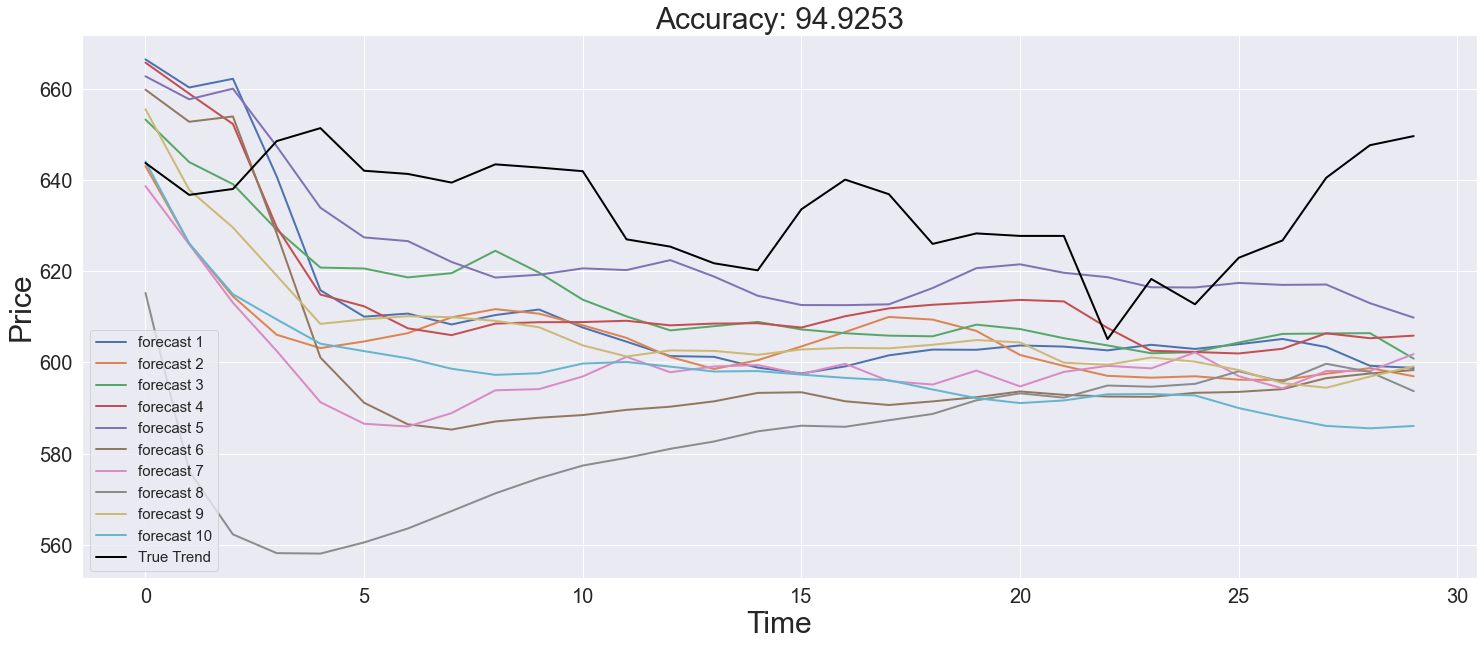

In [15]:
# Lets check the performance of model
accuracies = [calculate_accuracy(data['Close'].iloc[-test_size: ].values, r) for r in result]

plt.figure(figsize=[25,10])
for no, r in enumerate(result):
    plt.plot(r, label='forecast %d' %(no+1), linewidth=2)
plt.plot(data['Close'].iloc[-test_size: ].values, label='True Trend', c='black', linewidth=2)
plt.legend(fontsize=15)
plt.xlabel('Time', fontsize=30)
plt.ylabel('Price', fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('Accuracy: %.4f' %(np.mean(accuracies)), fontsize=30)
plt.show()

# 2) Single Layer Bidirectional LSTM

In [16]:
# Building LSTM Architecture (Bidirectional)
class Model2(tf.keras.Model):
    def __init__(self, learning_rate, lstm_cells_no, lstm_layers_no, input_feature_size, output_size, bias=0.1):
        
        super(Model2, self).__init__()
        
        def lstm_layer(lstm_cells_no):
            return tf.compat.v1.nn.rnn_cell.LSTMCell(lstm_cells_no, state_is_tuple=False)
        
        multilayer_lstm_fw = tf.compat.v1.nn.rnn_cell.MultiRNNCell([lstm_layer(lstm_cells_no) for _ in range(lstm_layers_no)], 
                                                                    state_is_tuple=False) # Forward Path
        multilayer_lstm_bw = tf.compat.v1.nn.rnn_cell.MultiRNNCell([lstm_layer(lstm_cells_no) for _ in range(lstm_layers_no)], 
                                                                    state_is_tuple=False) # Backward Path
        
        self.X = tf.compat.v1.placeholder(tf.float32, (None, None, input_feature_size))
        self.y = tf.compat.v1.placeholder(tf.float32, (None, output_size))
        self.fw_hidden_layer = tf.compat.v1.placeholder(tf.float32, (None, lstm_cells_no*lstm_layers_no*2)) # Forward Path
        self.bw_hidden_layer = tf.compat.v1.placeholder(tf.float32, (None, lstm_cells_no*lstm_layers_no*2)) # Backward Path
        
        drop_fw = tf.compat.v1.nn.rnn_cell.DropoutWrapper(multilayer_lstm_fw, output_keep_prob=bias) # Forward Path
        drop_bw = tf.compat.v1.nn.rnn_cell.DropoutWrapper(multilayer_lstm_bw, output_keep_prob=bias) # Backward Path
        
        self.outputs, self.last_hidden_state = tf.compat.v1.nn.bidirectional_dynamic_rnn(drop_fw, drop_bw, self.X,
                                                                                        initial_state_fw=self.fw_hidden_layer,
                                                                                        initial_state_bw=self.bw_hidden_layer,
                                                                                        dtype=tf.float32)
        self.outputs = tf.concat([self.outputs], 2)
        self.logits = tf.compat.v1.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.reduce_mean(tf.square(self.y - self.logits))
        self.optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate).minimize(self.cost)
        
        
        
def calculate_accuracy(real, predicted):
    real = np.array(real)+1
    predicted = np.array(predicted)+1
    percentage = 1 - np.sqrt(np.mean(np.square((real-predicted)/real)))
    return percentage*100



def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = (last*weight) + ((1-weight)*i)
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

### In derived class Model2 we passed the stacked multilayer lstm (both fw and bw), initial hidden states, input sequences through bidirectional dynamic rnn. This allows the model to capture information from past and future. The resulting self.outputs will contain both forward and backward sequences, which are concatenated using tf.concat.  Bidirectional dynamic rnn is used when we want the input sequences to be processed in both fw and bw directions to capture entire sequence.

In [17]:
# Train the batches, forecast the future values
learning_rate = 0.01
lstm_cells_no = 128
lstm_layers_no = 1
dropout_rate = 0.8
epoches = 300
timestamp = 5

# Train the loop over specified no of epochs, make training in batches, update lstm model parameters through backpropogation 
# and record the loss and accuracy metrics for each epoch
def forecast2():
    tf.compat.v1.reset_default_graph()
    
    modellstmbi = Model2(learning_rate, lstm_cells_no, lstm_layers_no, df.shape[1], df.shape[1], dropout_rate)
    
    sess = tf.compat.v1.InteractiveSession()
    sess.run(tf.compat.v1.global_variables_initializer())
    date_ori = pd.to_datetime(data.iloc[:, 0]).tolist()
    
    pbar = tqdm(range(epoches), desc='Training loop')
    for p in pbar:
        initial_hidden_state_fw = np.zeros((1, lstm_cells_no*lstm_layers_no*2))
        initial_hidden_state_bw = np.zeros((1, lstm_cells_no*lstm_layers_no*2))
        total_loss, total_acc = [], []
        for k in range(0, train_df.shape[0]-1, timestamp):
            last_index = min(k+timestamp, train_df.shape[0]-1)
            batch_X = np.expand_dims(train_df.iloc[k : last_index, :].values, axis=0)
            batch_y = train_df.iloc[k+1 : last_index+1].values
            
            feed_dict = {modellstmbi.X : batch_X,
                        modellstmbi.y : batch_y,
                        modellstmbi.fw_hidden_layer : initial_hidden_state_fw,
                        modellstmbi.bw_hidden_layer : initial_hidden_state_bw}
            
            logits, last_hidden_state, gradients, loss = sess.run([modellstmbi.logits, modellstmbi.last_hidden_state,
                                                                  modellstmbi.optimizer, modellstmbi.cost], 
                                                                  feed_dict=feed_dict)
            
            initial_hidden_state_fw = last_hidden_state[0]
            initial_hidden_state_bw = last_hidden_state[1]
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
            
        pbar.set_postfix(cost=np.mean(total_loss), acc=np.mean(total_acc))
        
        
        
        
 # Forecasting using trained lstm model on the batches of training data and also on remaining data points        
    future_days = test_size
    output_prediction = np.zeros((train_df.shape[0]+future_days, train_df.shape[1]))
    output_prediction[0] = train_df.iloc[0]
    upper_bound = (train_df.shape[0] // timestamp)*timestamp
    initial_hidden_state_fw = np.zeros((1, lstm_cells_no*lstm_layers_no*2))
    initial_hidden_state_bw = np.zeros((1, lstm_cells_no*lstm_layers_no*2))
    
    for k in range(0, upper_bound, timestamp):
        output_logits, last_hidden_state = sess.run([modellstmbi.logits, modellstmbi.last_hidden_state],
                                            feed_dict={modellstmbi.X : np.expand_dims(train_df.iloc[k : k+timestamp].values, 
                                                                                     axis=0), 
                                                      modellstmbi.fw_hidden_layer : initial_hidden_state_fw, 
                                                      modellstmbi.bw_hidden_layer : initial_hidden_state_bw})
        
        initial_hidden_state_fw = last_hidden_state[0]
        initial_hidden_state_bw = last_hidden_state[1]
        output_prediction[k+1 : k+timestamp+1] = output_logits
        
    if upper_bound != train_df.shape[0]:
        output_logits, last_hidden_state = sess.run([modellstmbi.logits, modellstmbi.last_hidden_state],
                                            feed_dict={modellstmbi.X : np.expand_dims(train_df.iloc[upper_bound : ].values, 
                                                                                     axis=0), 
                                                      modellstmbi.fw_hidden_layer : initial_hidden_state_fw, 
                                                      modellstmbi.bw_hidden_layer : initial_hidden_state_bw})
        
        output_prediction[upper_bound+1 : train_df.shape[0]+1] = output_logits
        future_days -= 1
        date_ori.append(date_ori[-1] + timedelta(days=1))
        
    initial_hidden_state_fw = last_hidden_state[0]
    initial_hidden_state_bw = last_hidden_state[1]
    
    
    
    
# Forecasting for each of the future days to get output     
    for i in range(future_days):
        sliceo = output_prediction[-future_days - timestamp + i : -future_days + i]
        output_logits, last_hidden_state = sess.run([modellstmbi.logits, modellstmbi.last_hidden_state],
                                            feed_dict={modellstmbi.X : np.expand_dims(sliceo, 
                                                                                     axis=0), 
                                                      modellstmbi.fw_hidden_layer : initial_hidden_state_fw, 
                                                      modellstmbi.bw_hidden_layer : initial_hidden_state_bw})
        
        initial_hidden_state_fw = last_hidden_state[0]
        initial_hidden_state_bw = last_hidden_state[1]
        output_prediction[-future_days + i] = output_logits[-1][0]
        date_ori.append(date_ori[-1] + timedelta(days=1))
        
    output_prediction = scaler.inverse_transform(output_prediction)
    future_pred = anchor(output_prediction[:,0], 0.3)
    
    return future_pred[-test_size: ]


In [18]:
# Run the simulation
result2 = []
for i in range(simulation):
    print('simulation %d' %(i+1))
    result2.append(forecast2())

simulation 1
Instructions for updating:
Please use `keras.layers.Bidirectional(keras.layers.RNN(cell))`, which is equivalent to this API


Training loop: 100%|█████████████████████████████████████████| 300/300 [01:13<00:00,  4.06it/s, acc=94.6, cost=0.00226]


simulation 2


Training loop: 100%|█████████████████████████████████████████| 300/300 [01:12<00:00,  4.16it/s, acc=94.5, cost=0.00221]


simulation 3


Training loop: 100%|█████████████████████████████████████████| 300/300 [01:15<00:00,  3.98it/s, acc=94.6, cost=0.00218]


simulation 4


Training loop: 100%|███████████████████████████████████████████| 300/300 [01:10<00:00,  4.28it/s, acc=95, cost=0.00231]


simulation 5


Training loop: 100%|█████████████████████████████████████████| 300/300 [01:09<00:00,  4.29it/s, acc=94.6, cost=0.00199]


simulation 6


Training loop: 100%|█████████████████████████████████████████| 300/300 [01:09<00:00,  4.29it/s, acc=94.3, cost=0.00293]


simulation 7


Training loop: 100%|█████████████████████████████████████████| 300/300 [01:10<00:00,  4.26it/s, acc=93.9, cost=0.00339]


simulation 8


Training loop: 100%|█████████████████████████████████████████| 300/300 [01:10<00:00,  4.28it/s, acc=93.6, cost=0.00337]


simulation 9


Training loop: 100%|██████████████████████████████████████████| 300/300 [01:10<00:00,  4.24it/s, acc=94.4, cost=0.0032]


simulation 10


Training loop: 100%|█████████████████████████████████████████| 300/300 [01:08<00:00,  4.35it/s, acc=94.2, cost=0.00258]


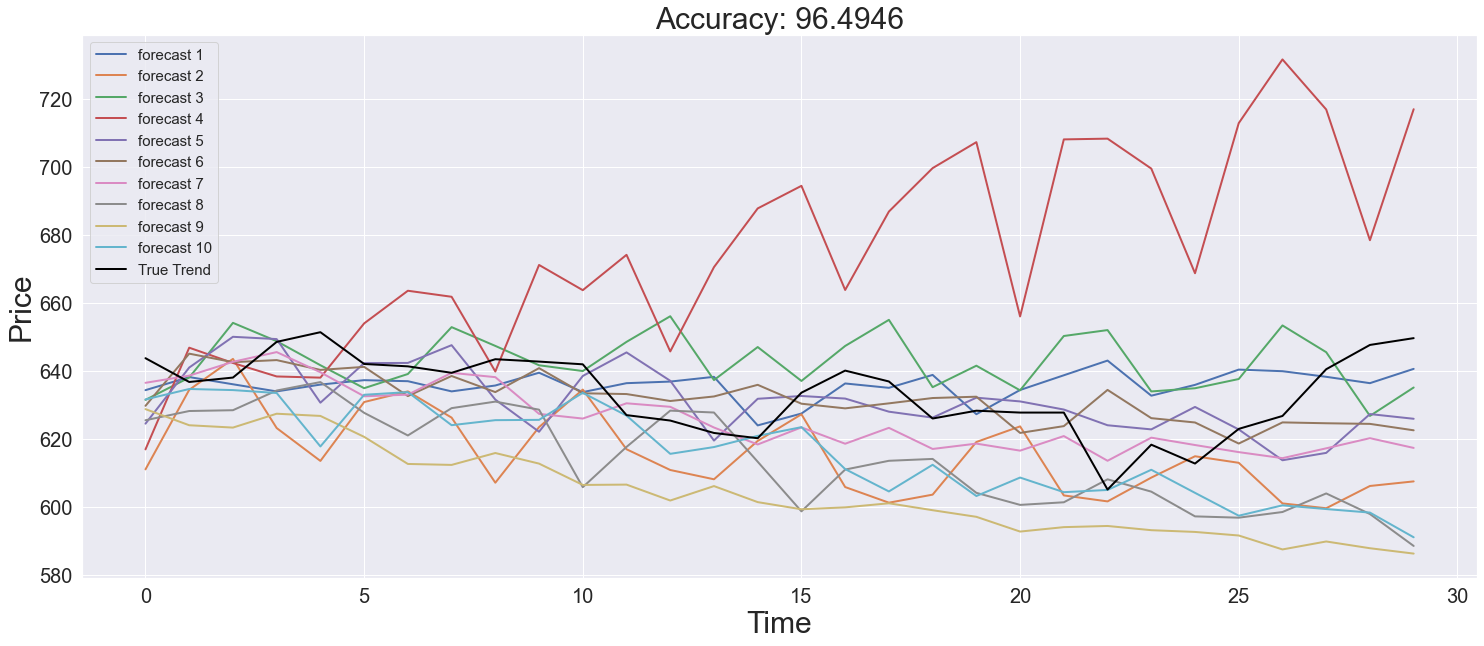

In [19]:
# Lets check the performance of model
accuracies = [calculate_accuracy(data['Close'].iloc[-test_size: ].values, j) for j in result2]

plt.figure(figsize=[25,10])
for no, j in enumerate(result2):
    plt.plot(j, label='forecast %d' %(no+1), linewidth=2)
plt.plot(data['Close'].iloc[-test_size: ].values, label='True Trend', c='black', linewidth=2)
plt.legend(fontsize=15)
plt.xlabel('Time', fontsize=30)
plt.ylabel('Price', fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('Accuracy: %.4f' %(np.mean(accuracies)), fontsize=30)
plt.show()

# 3) LSTM 2 Path (Using Variable Scope)

In [60]:
# Building LSTM Architecture with variable scope
class Model3(tf.keras.Model):
    def __init__(self, learning_rate, lstm_cells_no, lstm_layers_no, input_feature_size, output_size, bias=0.1):
        super(Model3, self).__init__()

        def lstm_layer(lstm_cells_no):
            return tf.compat.v1.nn.rnn_cell.LSTMCell(lstm_cells_no, state_is_tuple=False)

        with tf.compat.v1.variable_scope('forward', reuse=False):
            multilayer_fw = tf.compat.v1.nn.rnn_cell.MultiRNNCell([lstm_layer(lstm_cells_no) for _ in range(lstm_layers_no)],
                                                                 state_is_tuple=False)

            self.X_fw = tf.compat.v1.placeholder(tf.float32, (None, None, input_feature_size))
            self.hidden_state_fw = tf.compat.v1.placeholder(tf.float32, (None, lstm_cells_no * lstm_layers_no * 2))

            drop_fw = tf.compat.v1.nn.rnn_cell.DropoutWrapper(multilayer_fw, output_keep_prob=bias)

            self.outputs_fw, self.last_hidden_state_fw = tf.compat.v1.nn.dynamic_rnn(drop_fw, self.X_fw,
                                                                                     initial_state=self.hidden_state_fw,
                                                                                     dtype=tf.float32)

        with tf.compat.v1.variable_scope('backward', reuse=False):
            multilayer_bw = tf.compat.v1.nn.rnn_cell.MultiRNNCell([lstm_layer(lstm_cells_no) for _ in range(lstm_layers_no)],
                                                                 state_is_tuple=False)

            self.X_bw = tf.compat.v1.placeholder(tf.float32, (None, None, input_feature_size))
            self.hidden_state_bw = tf.compat.v1.placeholder(tf.float32, (None, lstm_cells_no * lstm_layers_no * 2))

            drop_bw = tf.compat.v1.nn.rnn_cell.DropoutWrapper(multilayer_bw, output_keep_prob=bias)

            self.outputs_bw, self.last_hidden_state_bw = tf.compat.v1.nn.dynamic_rnn(drop_bw, self.X_bw,
                                                                                    initial_state=self.hidden_state_bw,
                                                                                    dtype=tf.float32)

        self.outputs = self.outputs_bw - self.outputs_fw
        self.y = tf.compat.v1.placeholder(tf.float32, (None, output_size))
        self.logits = tf.compat.v1.layers.dense(self.outputs[:, -1, :], output_size)
        self.cost = tf.reduce_mean(tf.square(self.y - self.logits))
        self.optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate).minimize(self.cost)
        
        
        
def calculate_accuracy(real, predicted):
    real = np.array(real)+1
    predicted = np.array(predicted)+1
    percentage = 1 - np.sqrt(np.mean(np.square((real - predicted) / real)))
    return percentage*100



def anchor(signals, weight):
    last = signals[0]
    buffer = []
    for i in signals:
        smoothed_val = (last*weight) + ((1-weight)*i)
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

### The bidirectional lstm processes the input sequence both in forward and backward directions, which internally take care of create and manage variables. The variable scope is used to create the scope of variables. It allows us to customize or differentiate the processes happening in forward and backward dir. This explicit seperation is usefull when we want to introduce variations or modifications specific to each dir. The difference lies in level of control and customization.

In [61]:
# Train the batches, forecast the future values
learning_rate = 0.01
lstm_cells_no = 128
lstm_layers_no = 1
dropout_rate = 0.8
epoches = 300
timestamp = 5

def forecast3():
    tf.compat.v1.reset_default_graph()
    tf.compat.v1.disable_eager_execution()
    modellstm2path = Model3(learning_rate, lstm_cells_no, lstm_layers_no, df.shape[1], df.shape[1], dropout_rate)
    
    sess = tf.compat.v1.InteractiveSession()
    sess.run(tf.compat.v1.global_variables_initializer())
    date_ori = pd.to_datetime(data.iloc[:, 0]).tolist()
    
    pbar = tqdm(range(epoches), desc = 'Training loop')
    for p in pbar:
        intial_hidden_state_fw = np.zeros((1, lstm_cells_no*lstm_layers_no*2))
        intial_hidden_state_bw = np.zeros((1, lstm_cells_no*lstm_layers_no*2))
        total_loss, total_acc = [], []
        for k in range(0, train_df.shape[0]-1, timestamp):
            last_index = min(k+timestamp, train_df.shape[0])
            batch_X_fw = np.expand_dims(train_df.iloc[k : last_index, :].values, axis=0)
            batch_X_bw = np.expand_dims(np.flip(train_df.iloc[k : last_index, :].values, axis=0), axis=0)
            batch_y = train_df.iloc[k+1 : last_index+1, :].values
            
            
            feed_dict = {modellstm2path.X_fw : batch_X_fw,
                        modellstm2path.X_bw : batch_X_bw,
                        modellstm2path.hidden_state_fw : intial_hidden_state_fw,
                        modellstm2path.hidden_state_bw : intial_hidden_state_bw,
                        modellstm2path.y : batch_y}
            
            logits, last_hidden_state_fw, last_hidden_state_bw, gradients, loss = sess.run([modellstm2path.logits,
                                                                                        modellstm2path.last_hidden_state_fw,
                                                                                        modellstm2path.last_hidden_state_bw,
                                                                                        modellstm2path.optimizer,
                                                                                        modellstm2path.cost], 
                                                                                           feed_dict=feed_dict)
            
            intial_hidden_state_fw = last_hidden_state_fw
            intial_hidden_state_bw = last_hidden_state_bw
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
            
        pbar.set_postfix(cost=np.mean(total_loss), acc=np.mean(total_acc))
        
        
        
        
        
        
        future_days = test_size
        output_predictions = np.zeros((train_df.shape[0]+future_days, train_df.shape[1]))
        output_predictions[0] = train_df.iloc[0]
        upper_bound = (train_df.shape[0] // timestamp)*timestamp
        intial_hidden_state_fw = np.zeros((1, lstm_cells_no*lstm_layers_no*2))
        intial_hidden_state_bw = np.zeros((1, lstm_cells_no*lstm_layers_no*2))
        for k in range(0, upper_bound, timestamp):
            
            output_logits, last_hidden_state_fw, last_hidden_state_bw = sess.run([modellstm2path.logits,
                                                                                 modellstm2path.last_hidden_state_fw,
                                                                                 modellstm2path.last_hidden_state_bw],
                                                                                feed_dict={modellstm2path.X_fw : 
                                                                                           np.expand_dims(train_df.iloc[k : k+timestamp, : ].values, axis=0),
                                                                                          modellstm2path.X_bw : np.expand_dims(np.flip(train_df.iloc[k : k+timestamp, : ].values, axis=0), axis=0),
                                                                                          modellstm2path.hidden_state_fw : intial_hidden_state_fw,
                                                                                          modellstm2path.hidden_state_bw : intial_hidden_state_bw})
            
            
            intial_hidden_state_fw = last_hidden_state_fw
            intial_hidden_state_bw = last_hidden_state_bw
            output_predictions[k+1 : k+timestamp+1, :] = output_logits
            
        if upper_bound != train_df.shape[0]:
            
            output_logits, last_hidden_state_fw, last_hidden_state_bw = sess.run([modellstm2path.logits,
                                                                                 modellstm2path.last_hidden_state_fw,
                                                                                 modellstm2path.last_hidden_state_bw],
                                                                                feed_dict={modellstm2path.X_fw : 
                                                                                           np.expand_dims(train_df.iloc[upper_bound :, :].values, axis=0),
                                                                                          modellstm2path.X_bw : np.expand_dims(np.flip(train_df.iloc[upper_bound :, :].values, axis=0), axis=0),
                                                                                          modellstm2path.hidden_state_fw : intial_hidden_state_fw,
                                                                                          modellstm2path.hidden_state_bw : intial_hidden_state_bw})
            
            intial_hidden_state_fw = last_hidden_state_fw
            intial_hidden_state_bw = last_hidden_state_bw
            output_predictions[upper_bound + 1 : train_df.shape[0]+1] = output_logits
            future_days -= 1
            date_ori.append(date_ori[-1] + timedelta(days=1))
            
        intial_hidden_state_fw = last_hidden_state_fw
        intial_hidden_state_bw = last_hidden_state_bw
        
        

        
        
        
        
        for i in range(future_days):
            sliceo_fw = output_predictions[-future_days - timestamp + i : -future_days + i]
            sliceo_bw = np.flip(sliceo_fw, axis=0)
            
            output_logits, last_hidden_state_fw, last_hidden_state_bw = sess.run([modellstm2path.logits,
                                                                                 modellstm2path.last_hidden_state_fw,
                                                                                 modellstm2path.last_hidden_state_bw],
                                                                                feed_dict={modellstm2path.X_fw : 
                                                                                           np.expand_dims(sliceo_fw, axis=0),
                                                                                          modellstm2path.X_bw : np.expand_dims(sliceo_bw, axis=0),
                                                                                          modellstm2path.hidden_state_fw : intial_hidden_state_fw,
                                                                                          modellstm2path.hidden_state_bw : intial_hidden_state_bw})
            
            intial_hidden_state_fw = last_hidden_state_fw                                    
            intial_hidden_state_bw = last_hidden_state_bw
            output_predictions[-future_days + i] = output_logits[-1]
            date_ori.append(date_ori[-1] + timedelta(days=1))
            
            
    output_predictions = scaler.inverse_transform(output_predictions)
    future_pred = anchor(output_predictions[:,0], 0.3)
    
    return future_pred[-test_size: ]
            

In [62]:
# Run the simulation
result3 = []
for i in range(simulation):
    print('simulation %d' %(i+1))
    result3.append(forecast3())

simulation 1


Training loop: 100%|█████████████████████████████████████████| 300/300 [02:10<00:00,  2.31it/s, acc=96.4, cost=0.00366]

simulation 2



Training loop: 100%|█████████████████████████████████████████| 300/300 [02:08<00:00,  2.33it/s, acc=95.2, cost=0.00538]

simulation 3



Training loop: 100%|█████████████████████████████████████████| 300/300 [02:13<00:00,  2.24it/s, acc=96.4, cost=0.00344]

simulation 4



Training loop: 100%|█████████████████████████████████████████| 300/300 [02:10<00:00,  2.31it/s, acc=96.1, cost=0.00371]

simulation 5



Training loop: 100%|█████████████████████████████████████████| 300/300 [02:14<00:00,  2.23it/s, acc=96.2, cost=0.00365]

simulation 6



Training loop: 100%|█████████████████████████████████████████| 300/300 [02:25<00:00,  2.07it/s, acc=95.8, cost=0.00423]

simulation 7



Training loop: 100%|█████████████████████████████████████████| 300/300 [02:21<00:00,  2.13it/s, acc=96.4, cost=0.00323]

simulation 8



Training loop: 100%|█████████████████████████████████████████| 300/300 [02:12<00:00,  2.27it/s, acc=96.5, cost=0.00324]

simulation 9



Training loop: 100%|█████████████████████████████████████████| 300/300 [02:13<00:00,  2.25it/s, acc=96.6, cost=0.00306]

simulation 10



Training loop: 100%|██████████████████████████████████████████| 300/300 [02:13<00:00,  2.25it/s, acc=96.6, cost=0.0031]


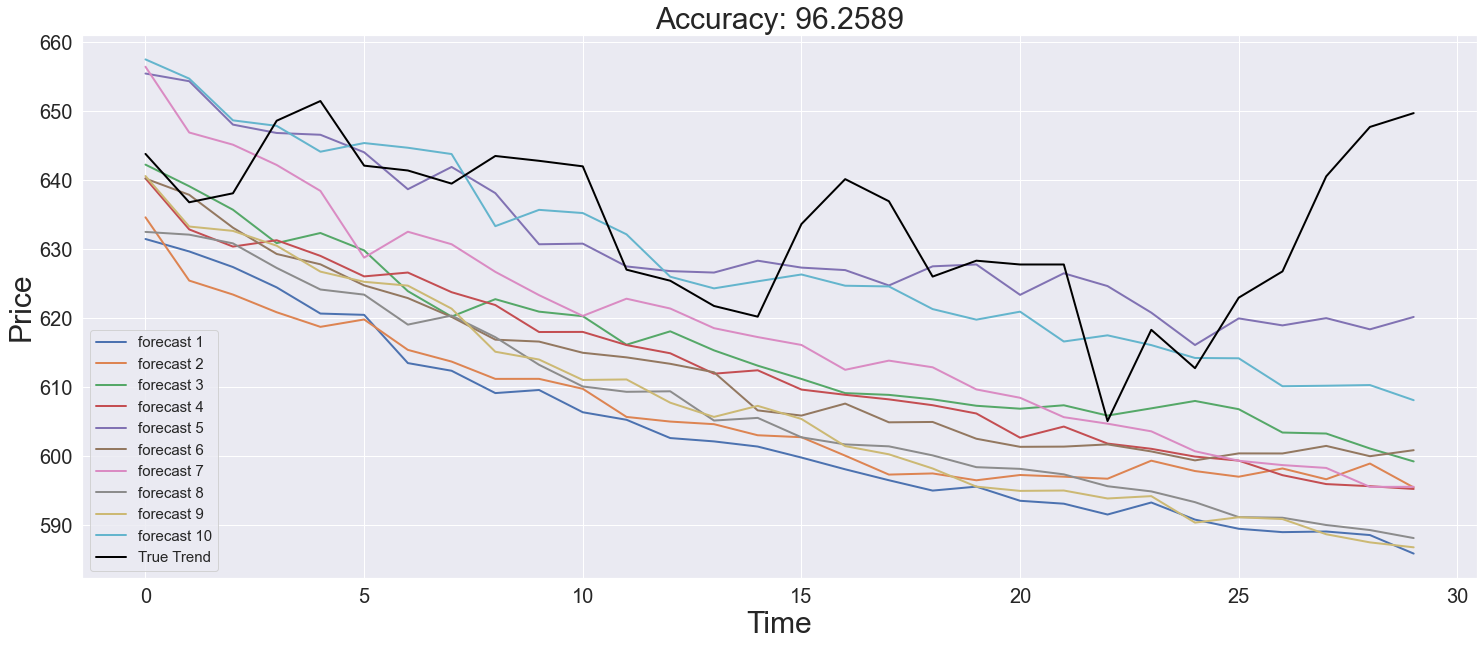

In [63]:
# Lets check the performance of model
accuracies = [calculate_accuracy(data['Close'].iloc[-test_size: ].values, i) for i in result3]

plt.figure(figsize=[25,10])
for no, i in enumerate(result3):
    plt.plot(i, label='forecast %d' %(no+1), linewidth=2)
plt.plot(data['Close'].iloc[-test_size: ].values, label='True Trend', c='black', linewidth=2)
plt.legend(fontsize=15)
plt.xlabel('Time', fontsize=30)
plt.ylabel('Price', fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('Accuracy: %.4f' %(np.mean(accuracies)), fontsize=30)
plt.show()

# 4) Single Layer GRU

In [127]:
# Building GRU Architecture
class Model4(tf.keras.Model):
    def __init__(self, learning_rate, gru_cells_no, gru_layers_no, input_feature_size, output_size, bias=0.1):
        
        super(Model4, self).__init__()
        
        def gru_layer(gru_cells_no):
            return tf.compat.v1.nn.rnn_cell.GRUCell(gru_cells_no) # Single layer GRU
        
        self.multilayer = tf.compat.v1.nn.rnn_cell.MultiRNNCell([gru_layer(gru_cells_no) for _ in range(gru_layers_no)],
                                                          state_is_tuple=False) # Stacked multilayer GRU
        
        self.X = tf.compat.v1.placeholder(tf.float32, (None, None, input_feature_size))
        self.y = tf.compat.v1.placeholder(tf.float32, (None, output_size))
        self.hidden_layer = tf.compat.v1.placeholder(tf.float32, (None, (gru_cells_no*gru_layers_no)))
        
        drop = tf.compat.v1.nn.rnn_cell.DropoutWrapper(self.multilayer, output_keep_prob=bias)
        
        self.outputs, self.last_hidden_state = tf.compat.v1.nn.dynamic_rnn(drop, self.X, initial_state=self.hidden_layer,
                                                                          dtype=tf.float32)
        
        self.logits = tf.compat.v1.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.reduce_mean(tf.square(self.y - self.logits))
        self.optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate).minimize(self.cost)
        
        
        
def calculate_accuarcy(real, predicted):
    real = np.array(real)+1
    predicted = np.array(predicted)+1
    percentage = 1 - np.sqrt(np.mean(np.square((real-predicted)/real)))
    return percentage*100


def anchor(signals, weight):
    buffer = []
    last = signals[0]
    for i in signals:
        smoothed_val = (last*weight) + ((1-weight)*i)
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer
        

In [128]:
learning_rate = 0.01
gru_cells_no = 128
gru_layers_no = 1
dropout_rate = 0.8
epoches = 300
timestamp = 5

# Train the loop over specified no of epochs, make training in batches, update lstm model parameters through backpropogation 
# and record the loss and accuracy metrics for each epoch
def forecast4():
    
    tf.compat.v1.reset_default_graph()
    modelgru = Model4(learning_rate, gru_cells_no, gru_layers_no, df.shape[1], df.shape[1], dropout_rate)
    sess = tf.compat.v1.InteractiveSession()
    sess.run(tf.compat.v1.global_variables_initializer())
    date_ori = pd.to_datetime(data.iloc[:, 0]).tolist()
    
    # Creating progress bar for the training loop that iterates over number of epoches 
    pbar = tqdm(range(epoches), desc = 'training_loop')
    for i in pbar:
        initial_hidden_state = np.zeros((1, gru_layers_no*gru_cells_no))
        total_loss, total_acc = [], []
        for k in range(0, train_df.shape[0]-1, timestamp):
            last_index = min(k+timestamp, train_df.shape[0]-1)
            batch_X = np.expand_dims(train_df.iloc[k:last_index, :].values, axis=0)
            batch_y = train_df.iloc[k+1:last_index+1, :].values
            
            feed_dict = {
                modelgru.X: batch_X,
                modelgru.y: batch_y,
                modelgru.hidden_layer: initial_hidden_state,
            }
            
            logits, gradients, last_hidden_state, loss = sess.run(
                [modelgru.logits, modelgru.optimizer, modelgru.last_hidden_state, modelgru.cost],
                feed_dict=feed_dict
            )
            
            initial_hidden_state = last_hidden_state
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:,0], logits[:,0]))
            
        pbar.set_postfix(cost=np.mean(total_loss), acc=np.mean(total_acc))
        
        
        
        
        
# Forecasting using trained lstm model on the batches of training data and also on remaining data points
    future_days = test_size
    output_prediction = np.zeros((train_df.shape[0]+future_days, train_df.shape[1]))
    output_prediction[0] = train_df.iloc[0]
    upper_bound = (train_df.shape[0] // timestamp)*timestamp
    initial_hidden_state = np.zeros((1, gru_layers_no*gru_cells_no))
    
    for k in range(0, upper_bound, timestamp):
        
        output_logits, last_hidden_state = sess.run(
            [modelgru.logits, modelgru.last_hidden_state],
            feed_dict={
                modelgru.X: np.expand_dims(
                    train_df.iloc[k: k + timestamp], axis=0
                ),
                modelgru.hidden_layer: initial_hidden_state,
            },
        )
        
        initial_hidden_state = last_hidden_state
        output_prediction[k+1: k+timestamp+1] = output_logits
        
    if upper_bound != train_df.shape[0]:
        
        output_logits, last_hidden_state = sess.run(
            [modelgru.logits, modelgru.last_hidden_state],
            feed_dict={
                modelgru.X: np.expand_dims(
                    train_df.iloc[upper_bound: ], axis=0
                ),
                modelgru.hidden_layer: initial_hidden_state,
            },
        )
        
        output_prediction[upper_bound+1: train_df.shape[0]+1] = output_logits
        future_days -= 1
        date_ori.append(date_ori[-1] + timedelta(days=1))

    initial_hidden_state = last_hidden_state
    
    
    
    
    
# Forecasting for each of the future days to get output 
    for i in range(future_days):
        sliceo = output_prediction[-future_days - timestamp + i: -future_days + i]
       
        output_logits, last_hidden_state = sess.run(
            [modelgru.logits, modelgru.last_hidden_state],
            feed_dict={
                modelgru.X: np.expand_dims(
                    sliceo, axis=0
                ),
                modelgru.hidden_layer: initial_hidden_state,
            },
        )
    
        initial_hidden_state = last_hidden_state
        output_prediction[-future_days + i] = output_logits[-1]
        date_ori.append(date_ori[-1] + timedelta(days=1))
        
        
    output_prediction = scaler.inverse_transform(output_prediction)
    future_pred = anchor(output_prediction[:,0], 0.3)
    
    return future_pred[-test_size: ]

In [129]:
# Run the simulation
result4 = []
for i in range(simulation):
    print('simulation %d' %(i+1))
    result4.append(forecast4())

simulation 1


training_loop: 100%|█████████████████████████████████████████| 300/300 [00:54<00:00,  5.53it/s, acc=96.1, cost=0.00368]

simulation 2



training_loop: 100%|█████████████████████████████████████████| 300/300 [00:54<00:00,  5.51it/s, acc=94.9, cost=0.00649]


simulation 3


training_loop: 100%|██████████████████████████████████████████| 300/300 [00:54<00:00,  5.51it/s, acc=86.2, cost=0.0465]


simulation 4


training_loop: 100%|███████████████████████████████████████████| 300/300 [00:53<00:00,  5.59it/s, acc=72.9, cost=0.187]


simulation 5


training_loop: 100%|███████████████████████████████████████████| 300/300 [00:53<00:00,  5.57it/s, acc=70.1, cost=0.204]


simulation 6


training_loop: 100%|█████████████████████████████████████████| 300/300 [00:54<00:00,  5.52it/s, acc=94.4, cost=0.00805]


simulation 7


training_loop: 100%|███████████████████████████████████████████| 300/300 [00:54<00:00,  5.48it/s, acc=72.6, cost=0.203]


simulation 8


training_loop: 100%|██████████████████████████████████████████| 300/300 [00:54<00:00,  5.52it/s, acc=80.2, cost=0.0937]

simulation 9



training_loop: 100%|█████████████████████████████████████████| 300/300 [00:53<00:00,  5.58it/s, acc=94.3, cost=0.00886]

simulation 10



training_loop: 100%|█████████████████████████████████████████| 300/300 [00:53<00:00,  5.58it/s, acc=95.5, cost=0.00447]


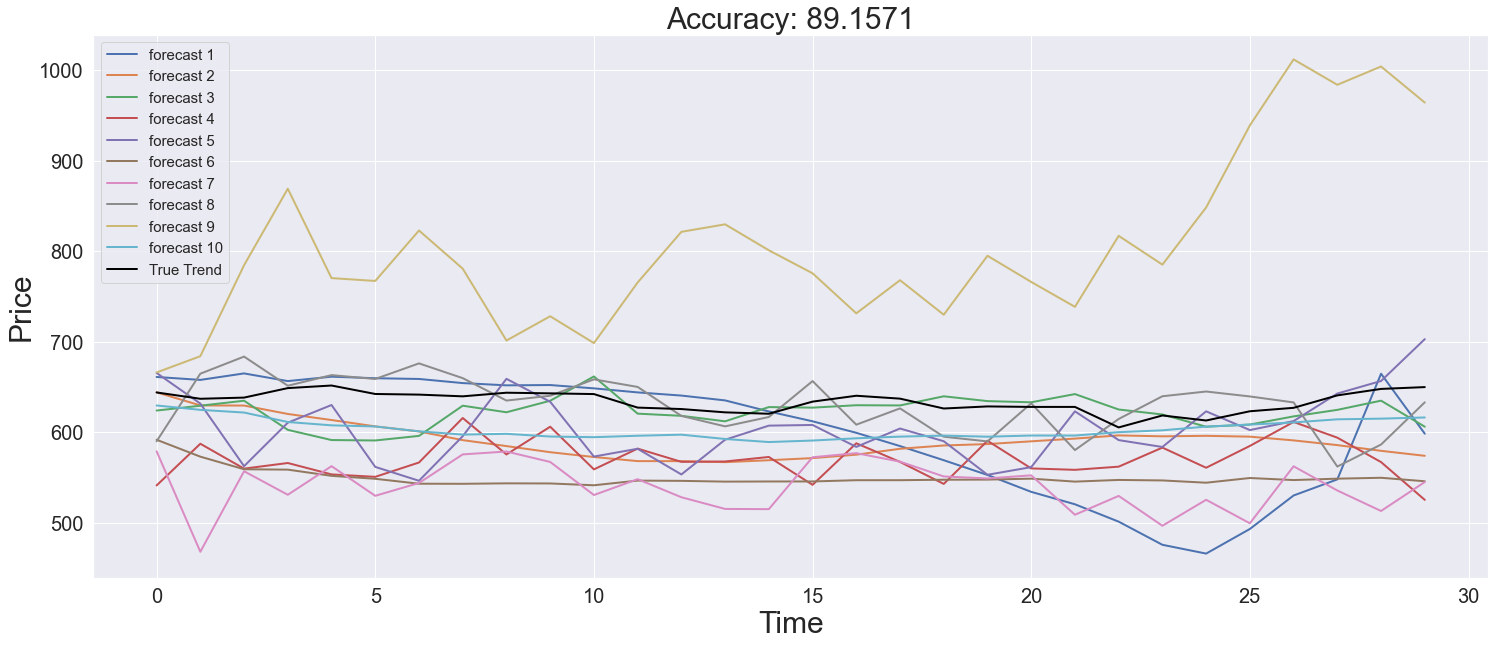

In [130]:
# Lets check the performance of model
accuracies = [calculate_accuracy(data['Close'].iloc[-test_size: ].values, a) for a in result4]

plt.figure(figsize=[25,10])
for no, a in enumerate(result4):
    plt.plot(a, label='forecast %d' %(no+1), linewidth=2)
plt.plot(data['Close'].iloc[-test_size: ].values, label='True Trend', c='black', linewidth=2)
plt.legend(fontsize=15)
plt.xlabel('Time', fontsize=30)
plt.ylabel('Price', fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('Accuracy: %.4f' %(np.mean(accuracies)), fontsize=30)
plt.show()

# 5) Bidirectional GRU 

In [123]:
# Building LSTM Architecture (Bidirectional)
class Model5(tf.keras.Model):
    def __init__(self, learning_rate, gru_cells_no, gru_layers_no, input_feature_size, output_size, bias=0.1):
        
        super(Model5, self).__init__()
        
        def gru_layer(gru_cells_no):
            return tf.compat.v1.nn.rnn_cell.GRUCell(gru_cells_no)
        
        multilayer_gru_fw = tf.compat.v1.nn.rnn_cell.MultiRNNCell([gru_layer(gru_cells_no) for _ in range(gru_layers_no)], 
                                                                    state_is_tuple=False) # Forward Path
        multilayer_gru_bw = tf.compat.v1.nn.rnn_cell.MultiRNNCell([gru_layer(gru_cells_no) for _ in range(gru_layers_no)], 
                                                                    state_is_tuple=False) # Backward Path
        
        self.X = tf.compat.v1.placeholder(tf.float32, (None, None, input_feature_size))
        self.y = tf.compat.v1.placeholder(tf.float32, (None, output_size))
        self.fw_hidden_layer = tf.compat.v1.placeholder(tf.float32, (None, lstm_cells_no*lstm_layers_no)) # Forward Path
        self.bw_hidden_layer = tf.compat.v1.placeholder(tf.float32, (None, lstm_cells_no*lstm_layers_no)) # Backward Path
        
        drop_fw = tf.compat.v1.nn.rnn_cell.DropoutWrapper(multilayer_gru_fw, output_keep_prob=bias) # Forward Path
        drop_bw = tf.compat.v1.nn.rnn_cell.DropoutWrapper(multilayer_gru_bw, output_keep_prob=bias) # Backward Path
        
        self.outputs, self.last_hidden_state = tf.compat.v1.nn.bidirectional_dynamic_rnn(drop_fw, drop_bw, self.X,
                                                                                        initial_state_fw=self.fw_hidden_layer,
                                                                                        initial_state_bw=self.bw_hidden_layer,
                                                                                        dtype=tf.float32)
        self.outputs = tf.concat([self.outputs], 2)
        self.logits = tf.compat.v1.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.reduce_mean(tf.square(self.y - self.logits))
        self.optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate).minimize(self.cost)
        
        
        
def calculate_accuracy(real, predicted):
    real = np.array(real)+1
    predicted = np.array(predicted)+1
    percentage = 1 - np.sqrt(np.mean(np.square((real-predicted)/real)))
    return percentage*100



def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = (last*weight) + ((1-weight)*i)
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

In [124]:
# Train the batches, forecast the future values
learning_rate = 0.01
gru_cells_no = 128
gru_layers_no = 1
dropout_rate = 0.8
epoches = 300
timestamp = 5

# Train the loop over specified no of epochs, make training in batches, update lstm model parameters through backpropogation 
# and record the loss and accuracy metrics for each epoch
def forecast5():
    tf.compat.v1.reset_default_graph()
    
    modelgrubi = Model5(learning_rate, gru_cells_no, gru_layers_no, df.shape[1], df.shape[1], dropout_rate)
    
    sess = tf.compat.v1.InteractiveSession()
    sess.run(tf.compat.v1.global_variables_initializer())
    date_ori = pd.to_datetime(data.iloc[:, 0]).tolist()
    
    pbar = tqdm(range(epoches), desc='Training loop')
    for p in pbar:
        initial_hidden_state_fw = np.zeros((1, gru_cells_no*gru_layers_no))
        initial_hidden_state_bw = np.zeros((1, gru_cells_no*gru_layers_no))
        total_loss, total_acc = [], []
        for k in range(0, train_df.shape[0]-1, timestamp):
            last_index = min(k+timestamp, train_df.shape[0]-1)
            batch_X = np.expand_dims(train_df.iloc[k : last_index, :].values, axis=0)
            batch_y = train_df.iloc[k+1 : last_index+1].values
            
            feed_dict = {modelgrubi.X : batch_X,
                        modelgrubi.y : batch_y,
                        modelgrubi.fw_hidden_layer : initial_hidden_state_fw,
                        modelgrubi.bw_hidden_layer : initial_hidden_state_bw}
            
            logits, last_hidden_state, gradients, loss = sess.run([modelgrubi.logits, modelgrubi.last_hidden_state,
                                                                  modelgrubi.optimizer, modelgrubi.cost], 
                                                                  feed_dict=feed_dict)
            
            initial_hidden_state_fw = last_hidden_state[0]
            initial_hidden_state_bw = last_hidden_state[1]
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
            
        pbar.set_postfix(cost=np.mean(total_loss), acc=np.mean(total_acc))
        
        
        
        
 # Forecasting using trained lstm model on the batches of training data and also on remaining data points        
    future_days = test_size
    output_prediction = np.zeros((train_df.shape[0]+future_days, train_df.shape[1]))
    output_prediction[0] = train_df.iloc[0]
    upper_bound = (train_df.shape[0] // timestamp)*timestamp
    initial_hidden_state_fw = np.zeros((1, gru_cells_no*gru_layers_no))
    initial_hidden_state_bw = np.zeros((1, gru_cells_no*gru_layers_no))
    
    for k in range(0, upper_bound, timestamp):
        output_logits, last_hidden_state = sess.run([modelgrubi.logits, modelgrubi.last_hidden_state],
                                            feed_dict={modelgrubi.X : np.expand_dims(train_df.iloc[k : k+timestamp].values, 
                                                                                     axis=0), 
                                                      modelgrubi.fw_hidden_layer : initial_hidden_state_fw, 
                                                      modelgrubi.bw_hidden_layer : initial_hidden_state_bw})
        
        initial_hidden_state_fw = last_hidden_state[0]
        initial_hidden_state_bw = last_hidden_state[1]
        output_prediction[k+1 : k+timestamp+1] = output_logits
        
    if upper_bound != train_df.shape[0]:
        output_logits, last_hidden_state = sess.run([modelgrubi.logits, modelgrubi.last_hidden_state],
                                            feed_dict={modelgrubi.X : np.expand_dims(train_df.iloc[upper_bound : ].values, 
                                                                                     axis=0), 
                                                      modelgrubi.fw_hidden_layer : initial_hidden_state_fw, 
                                                      modelgrubi.bw_hidden_layer : initial_hidden_state_bw})
        
        output_prediction[upper_bound+1 : train_df.shape[0]+1] = output_logits
        future_days -= 1
        date_ori.append(date_ori[-1] + timedelta(days=1))
        
    initial_hidden_state_fw = last_hidden_state[0]
    initial_hidden_state_bw = last_hidden_state[1]
    
    
    
    
# Forecasting for each of the future days to get output     
    for i in range(future_days):
        sliceo = output_prediction[-future_days - timestamp + i : -future_days + i]
        output_logits, last_hidden_state = sess.run([modelgrubi.logits, modelgrubi.last_hidden_state],
                                            feed_dict={modelgrubi.X : np.expand_dims(sliceo, 
                                                                                     axis=0), 
                                                      modelgrubi.fw_hidden_layer : initial_hidden_state_fw, 
                                                      modelgrubi.bw_hidden_layer : initial_hidden_state_bw})
        
        initial_hidden_state_fw = last_hidden_state[0]
        initial_hidden_state_bw = last_hidden_state[1]
        output_prediction[-future_days + i] = output_logits[-1][0]
        date_ori.append(date_ori[-1] + timedelta(days=1))
        
    output_prediction = scaler.inverse_transform(output_prediction)
    future_pred = anchor(output_prediction[:,0], 0.3)
    
    return future_pred[-test_size: ]


In [125]:
# Run the simulation
result5 = []
for i in range(simulation):
    print('simulation %d' %(i+1))
    result5.append(forecast5())

simulation 1


Training loop: 100%|█████████████████████████████████████████| 300/300 [01:11<00:00,  4.18it/s, acc=93.7, cost=0.00801]


simulation 2


Training loop: 100%|█████████████████████████████████████████| 300/300 [01:10<00:00,  4.24it/s, acc=92.9, cost=0.00655]


simulation 3


Training loop: 100%|█████████████████████████████████████████| 300/300 [01:10<00:00,  4.28it/s, acc=93.9, cost=0.00483]


simulation 4


Training loop: 100%|██████████████████████████████████████████| 300/300 [01:11<00:00,  4.21it/s, acc=91.4, cost=0.0136]


simulation 5


Training loop: 100%|█████████████████████████████████████████| 300/300 [01:09<00:00,  4.30it/s, acc=93.9, cost=0.00538]


simulation 6


Training loop: 100%|███████████████████████████████████████████| 300/300 [01:11<00:00,  4.20it/s, acc=72.8, cost=0.201]


simulation 7


Training loop: 100%|█████████████████████████████████████████| 300/300 [01:09<00:00,  4.32it/s, acc=94.1, cost=0.00455]


simulation 8


Training loop: 100%|███████████████████████████████████████████| 300/300 [01:11<00:00,  4.20it/s, acc=94, cost=0.00528]


simulation 9


Training loop: 100%|█████████████████████████████████████████| 300/300 [01:10<00:00,  4.25it/s, acc=93.5, cost=0.00462]


simulation 10


Training loop: 100%|███████████████████████████████████████████| 300/300 [01:09<00:00,  4.34it/s, acc=94, cost=0.00404]


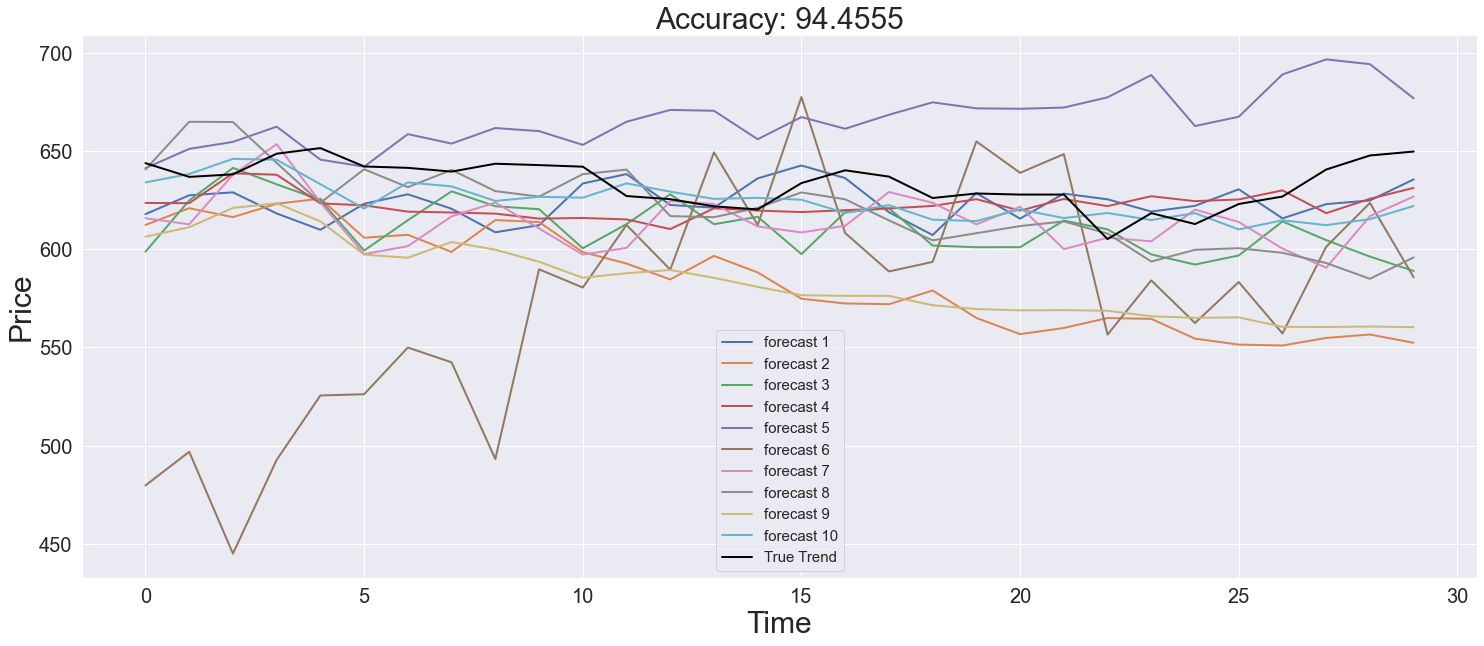

In [126]:
# Lets check the performance of model
accuracies = [calculate_accuracy(data['Close'].iloc[-test_size: ].values, b) for b in result5]

plt.figure(figsize=[25,10])
for no, b in enumerate(result5):
    plt.plot(b, label='forecast %d' %(no+1), linewidth=2)
plt.plot(data['Close'].iloc[-test_size: ].values, label='True Trend', c='black', linewidth=2)
plt.legend(fontsize=15)
plt.xlabel('Time', fontsize=30)
plt.ylabel('Price', fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('Accuracy: %.4f' %(np.mean(accuracies)), fontsize=30)
plt.show()

# 6) LSTM SeqToSeq

In [161]:
# Building the LSTM seq to seq model
class Model6(tf.keras.Model):
    
    def __init__(self, learning_rate, lstm_cells_no, lstm_layers_no, input_feature_size, output_size, bias=0.1):
        
        super(Model6, self).__init__()
        
        def lstm_layer(lstm_cells_no):
            return tf.compat.v1.nn.rnn_cell.LSTMCell(lstm_cells_no, state_is_tuple=False)
        
        self.multilayer = tf.compat.v1.nn.rnn_cell.MultiRNNCell([lstm_layer(lstm_cells_no) for _ in range(lstm_layers_no)],
                                                                       state_is_tuple=False)

        self.X = tf.compat.v1.placeholder(tf.float32, (None, None, input_feature_size))
        self.y = tf.compat.v1.placeholder(tf.float32, (None, output_size))
        self.hidden_layer = tf.compat.v1.placeholder(tf.float32, (None, lstm_cells_no*lstm_layers_no*2))
        
        drop = tf.compat.v1.nn.rnn_cell.DropoutWrapper(self.multilayer, output_keep_prob=bias)
        
        _, last_hidden_state = tf.compat.v1.nn.dynamic_rnn(drop, self.X, initial_state=self.hidden_layer, 
                                                               dtype=tf.float32)  # Encoder
        
        
        with tf.compat.v1.variable_scope('decoder', reuse=False):
            self.multilayer_dec = tf.compat.v1.nn.rnn_cell.MultiRNNCell([lstm_layer(lstm_cells_no) for _ in range(lstm_layers_no)],
                                                                       state_is_tuple=False)
            
            drop_dec = tf.compat.v1.nn.rnn_cell.DropoutWrapper(self.multilayer_dec, output_keep_prob=bias)
            
            self.outputs, self.last_hidden_state = tf.compat.v1.nn.dynamic_rnn(drop_dec, self.X, initial_state=last_hidden_state, 
                                                               dtype=tf.float32) # Decoder
            
            
        self.logits = tf.compat.v1.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.reduce_mean(tf.square(self.y - self.logits))
        self.optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate).minimize(self.cost)
        
        
        
        
def calculate_accuracy(real, predicted):
    real = np.array(real)+1
    predicted = np.array(predicted)+1
    percentage = 1 - np.sqrt(np.mean(np.square((real-predicted)/real)))
    return percentage*100



def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = (last*weight) + ((1-weight)*i)
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

### The single and multilayer stacked lstm network is prepared along with placeholders for input, output and initial hidden state. The stacked multilayer lstm is passed through dynamic rnn to get initial output and hidden state after performing input. In variable scope decoder id created to take output of dynamic rnn (last hidden state) as input to next dynamic rnn. The output of decoder is passed through final dense layer to get logits. The encoder takes the input seq and encodes this into fixed dimension vector. The decoder takes the output from encoder to generate output.

In [162]:
learning_rate = 0.01
lstm_layers_no = 1
lstm_cells_no = 128
dropout_rate = 0.8
epoches = 300
timestamp = 5

# Train the loop over specified no of epochs, make training in batches, update lstm model parameters through backpropogation 
# and record the loss and accuracy metrics for each epoch
def forecast6():

    tf.compat.v1.reset_default_graph()
    modellstmseqtoseq = Model6(learning_rate, lstm_cells_no, lstm_layers_no, df.shape[1], df.shape[1], dropout_rate)
    sess = tf.compat.v1.InteractiveSession()
    sess.run(tf.compat.v1.global_variables_initializer())
    date_ori = pd.to_datetime(data.iloc[:, 0]).tolist()
    
    # Creating progress bar for the training loop that iterates over number of epoches 
    pbar = tqdm(range(epoches), desc = 'training_loop')
    for i in pbar:
        initial_hidden_state = np.zeros((1, lstm_layers_no*lstm_cells_no*2))
        total_loss, total_acc = [], []
        for k in range(0, train_df.shape[0]-1, timestamp):
            last_index = min(k+timestamp, train_df.shape[0]-1)
            batch_X = np.expand_dims(train_df.iloc[k:last_index, :].values, axis=0)
            batch_y = train_df.iloc[k+1:last_index+1, :].values
            
            feed_dict = {
                modellstmseqtoseq.X: batch_X,
                modellstmseqtoseq.y: batch_y,
                modellstmseqtoseq.hidden_layer: initial_hidden_state,
            }
            
            logits, gradients, last_state, loss = sess.run(
                [modellstmseqtoseq.logits, modellstmseqtoseq.optimizer, modellstmseqtoseq.last_hidden_state, 
                 modellstmseqtoseq.cost],
                feed_dict=feed_dict
            )
            
            initial_hidden_state = last_state
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:,0], logits[:,0]))
            
        pbar.set_postfix(cost=np.mean(total_loss), acc=np.mean(total_acc))
        
        
        
        
        
# Forecasting using trained lstm model on the batches of training data and also on remaining data points
    future_days = test_size
    output_prediction = np.zeros((train_df.shape[0]+future_days, train_df.shape[1]))
    output_prediction[0] = train_df.iloc[0]
    upper_bound = (train_df.shape[0] // timestamp)*timestamp
    initial_hidden_state = np.zeros((1, lstm_layers_no*lstm_cells_no*2))
    
    for k in range(0, upper_bound, timestamp):
        
        output_logits, last_hidden_state = sess.run(
            [modellstmseqtoseq.logits, modellstmseqtoseq.last_hidden_state],
            feed_dict={
                modellstmseqtoseq.X: np.expand_dims(
                    train_df.iloc[k: k + timestamp], axis=0
                ),
                modellstmseqtoseq.hidden_layer: initial_hidden_state,
            },
        )
        
        initial_hidden_state = last_hidden_state
        output_prediction[k+1: k+timestamp+1] = output_logits
        
    if upper_bound != train_df.shape[0]:
        
        output_logits, last_hidden_state = sess.run(
            [modellstmseqtoseq.logits, modellstmseqtoseq.last_hidden_state],
            feed_dict={
                modellstmseqtoseq.X: np.expand_dims(
                    train_df.iloc[upper_bound: ], axis=0
                ),
                modellstmseqtoseq.hidden_layer: initial_hidden_state,
            },
        )
        
        output_prediction[upper_bound+1: train_df.shape[0]+1] = output_logits
        future_days -= 1
        date_ori.append(date_ori[-1] + timedelta(days=1))

    initial_hidden_state = last_hidden_state
    
    
    
    
    
# Forecasting for each of the future days to get output 
    for i in range(future_days):
        sliceo = output_prediction[-future_days - timestamp + i: -future_days + i]
       
        output_logits, last_hidden_state = sess.run(
            [modellstmseqtoseq.logits, modellstmseqtoseq.last_hidden_state],
            feed_dict={
                modellstmseqtoseq.X: np.expand_dims(
                    sliceo, axis=0
                ),
                modellstmseqtoseq.hidden_layer: initial_hidden_state,
            },
        )
    
        initial_hidden_state = last_hidden_state
        output_prediction[-future_days + i] = output_logits[-1]
        date_ori.append(date_ori[-1] + timedelta(days=1))
        
        
    output_prediction = scaler.inverse_transform(output_prediction)
    future_pred = anchor(output_prediction[:,0], 0.3)
    
    return future_pred[-test_size: ]


In [163]:
# Run the simulation
result6 = []
for i in range(simulation):
    print('simulation %d' %(i+1))
    result6.append(forecast6())

simulation 1


training_loop: 100%|████████████████████████████████████████| 300/300 [01:34<00:00,  3.18it/s, acc=98.6, cost=0.000483]


simulation 2


training_loop: 100%|█████████████████████████████████████████| 300/300 [01:34<00:00,  3.17it/s, acc=96.8, cost=0.00256]


simulation 3


training_loop: 100%|████████████████████████████████████████| 300/300 [01:31<00:00,  3.28it/s, acc=98.4, cost=0.000608]


simulation 4


training_loop: 100%|█████████████████████████████████████████| 300/300 [01:32<00:00,  3.23it/s, acc=96.1, cost=0.00408]


simulation 5


training_loop: 100%|████████████████████████████████████████| 300/300 [01:34<00:00,  3.16it/s, acc=98.1, cost=0.000933]


simulation 6


training_loop: 100%|█████████████████████████████████████████| 300/300 [01:32<00:00,  3.24it/s, acc=98.1, cost=0.00082]


simulation 7


training_loop: 100%|████████████████████████████████████████| 300/300 [01:34<00:00,  3.16it/s, acc=98.1, cost=0.000877]


simulation 8


training_loop: 100%|████████████████████████████████████████| 300/300 [01:41<00:00,  2.97it/s, acc=98.4, cost=0.000699]


simulation 9


training_loop: 100%|███████████████████████████████████████████| 300/300 [01:37<00:00,  3.07it/s, acc=97.9, cost=0.001]


simulation 10


training_loop: 100%|████████████████████████████████████████| 300/300 [01:33<00:00,  3.22it/s, acc=98.5, cost=0.000556]


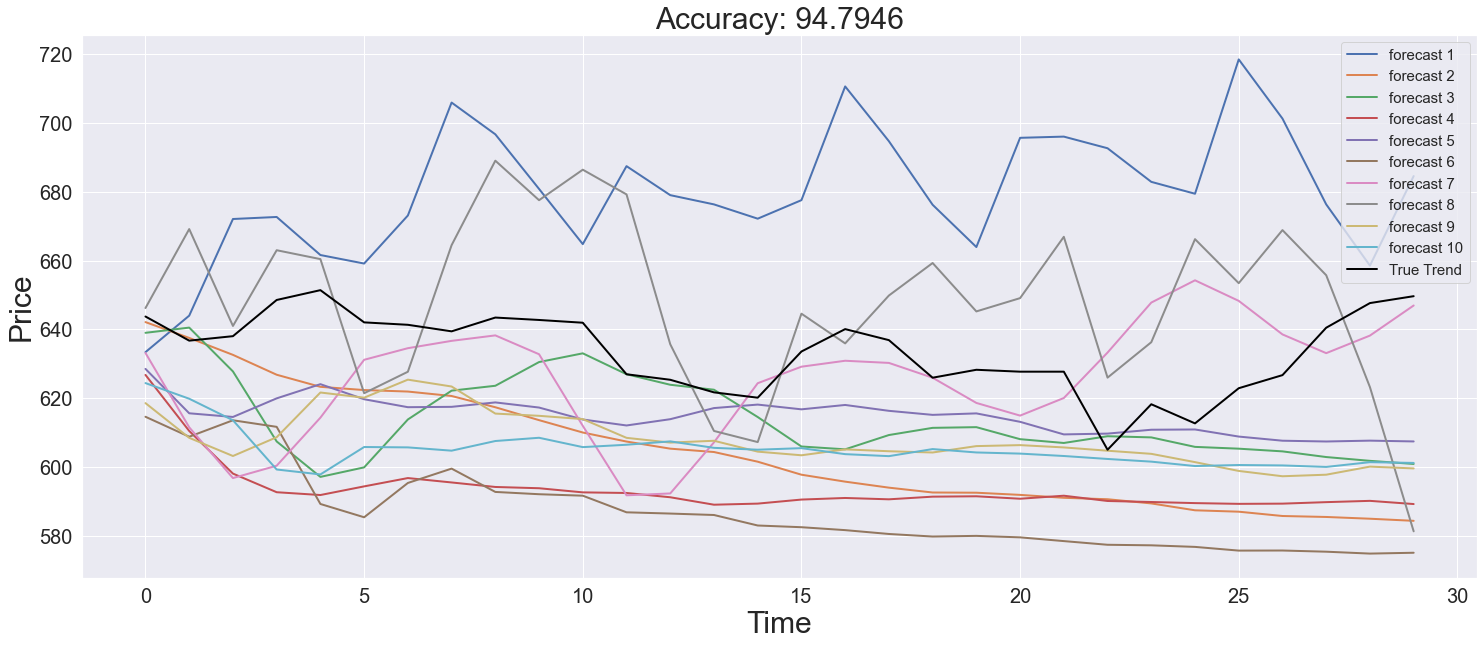

In [164]:
# Lets check the performance of model
accuracies = [calculate_accuracy(data['Close'].iloc[-test_size: ].values, c) for c in result6]

plt.figure(figsize=[25,10])
for no, c in enumerate(result6):
    plt.plot(c, label='forecast %d' %(no+1), linewidth=2)
plt.plot(data['Close'].iloc[-test_size: ].values, label='True Trend', c='black', linewidth=2)
plt.legend(fontsize=15)
plt.xlabel('Time', fontsize=30)
plt.ylabel('Price', fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('Accuracy: %.4f' %(np.mean(accuracies)), fontsize=30)
plt.show()

# 7) LSTM SeqToSeq VAE

In [166]:
# Building LSTM seq to seq VAE
class Model7(tf.keras.Model):
    
    def __init__(self, learning_rate, lstm_cells_no, lstm_layers_no, input_feature_size, output_size, bias=0.1,
                 lambda_coeff=0.5):
    
        super(Model7, self).__init__()
    
        def lstm_layer(lstm_cells_no):
            return tf.compat.v1.nn.rnn_cell.LSTMCell(lstm_cells_no, state_is_tuple=False)
    
        self.multilayer = tf.compat.v1.nn.rnn_cell.MultiRNNCell([lstm_layer(lstm_cells_no) for _ in range(lstm_layers_no)], 
                                                           state_is_tuple=False)
    
        self.X = tf.compat.v1.placeholder(tf.float32, (None, None, input_feature_size))
        self.y = tf.compat.v1.placeholder(tf.float32, (None, output_size))
        self.hidden_layer = tf.compat.v1.placeholder(tf.float32, (None, lstm_cells_no*lstm_layers_no*2))
    
        drop = tf.compat.v1.nn.rnn_cell.DropoutWrapper(self.multilayer, output_keep_prob=bias)
    
        _, last_hidden_state = tf.compat.v1.nn.dynamic_rnn(drop, self.X, initial_state=self.hidden_layer, dtype=tf.float32)
    
    
        self.z_mean = tf.compat.v1.layers.dense(last_hidden_state, input_feature_size)  # Guassian mean
        self.z_log_sigma = tf.compat.v1.layers.dense(last_hidden_state, input_feature_size) # Gaussian SD
        epsilon = tf.compat.v1.random_normal(tf.shape(self.z_log_sigma))  # Sampled noise from unit GD
        self.z_vector = self.z_mean + tf.exp(self.z_log_sigma)  # Latent space vector
    
    
        with tf.compat.v1.variable_scope('decoder', reuse=False):
            self.multilayer_dec = tf.compat.v1.nn.rnn_cell.MultiRNNCell([lstm_layer(lstm_cells_no) for _ in range(lstm_layers_no)], 
                                                           state_is_tuple=False)
        
            drop_dec = tf.compat.v1.nn.rnn_cell.DropoutWrapper(self.multilayer_dec, output_keep_prob=bias)
        
            x = tf.concat((tf.expand_dims(self.z_vector, axis=0), self.X), axis=1)
        
            self.outputs, self.last_hidden_state = tf.compat.v1.nn.dynamic_rnn(drop_dec, self.X, 
                                                                initial_state=last_hidden_state, dtype=tf.float32)
        
            self.logits = tf.compat.v1.layers.dense(self.outputs[-1], output_size)
        
            self.lambda_coeff = lambda_coeff
            self.KL_loss  = -0.5 * tf.reduce_sum(1 + (2*self.z_log_sigma) - (self.z_mean**2) - (tf.exp(2*self.z_log_sigma)), 1)
            self.KL_loss = tf.scalar_mul(self.lambda_coeff, self.KL_loss)  # KL divergence loss
        
            self.cost = tf.reduce_mean(tf.square(self.y - self.logits) + self.KL_loss) # Total loss ie reconstruction loss + KL loss
            self.optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate).minimize(self.cost)
        
        
        
        
def calculate_accuracy(real, predicted):
    real = np.array(real)+1
    predicted = np.array(predicted)+1
    percentage = 1 - np.sqrt(np.mean(np.square((real-predicted)/real)))
    return percentage*100



def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = (last*weight) + ((1-weight)*i)
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

### The VAE is used along with lstm seq to seq. This is generative model that captures the underlying structure of the input data and generates new data points. The objective is to map input data points to latent space representation (low dimension). Encoder maps input data pts to probabilistic distribution in latent space, which is a guassian dist with mean and SD. The random noise is sampled from unit GD and then scaled and shifted using lambda coeff, guassian mean and SD to get samples from learned latent distribution (Reparameterization). The decoder takes the output from encoder as a input (samples from LS) and reconstruct the original data pts, generates data points similar to OG input data. 

In [167]:
learning_rate = 0.01
lstm_layers_no = 1
lstm_cells_no = 128
dropout_rate = 0.8
epoches = 300
timestamp = 5

# Train the loop over specified no of epochs, make training in batches, update lstm model parameters through backpropogation 
# and record the loss and accuracy metrics for each epoch
def forecast7():

    tf.compat.v1.reset_default_graph()
    
    modellstmseqtoseq_vae = Model7(learning_rate, lstm_cells_no, lstm_layers_no, df.shape[1], df.shape[1], dropout_rate)
    
    sess = tf.compat.v1.InteractiveSession()
    sess.run(tf.compat.v1.global_variables_initializer())
    date_ori = pd.to_datetime(data.iloc[:, 0]).tolist()
    
    # Creating progress bar for the training loop that iterates over number of epoches 
    pbar = tqdm(range(epoches), desc = 'training_loop')
    for i in pbar:
        initial_hidden_state = np.zeros((1, lstm_layers_no*lstm_cells_no*2))
        total_loss, total_acc = [], []
        for k in range(0, train_df.shape[0]-1, timestamp):
            last_index = min(k+timestamp, train_df.shape[0]-1)
            
            batch_X = np.expand_dims(train_df.iloc[k:last_index, :].values, axis=0)
            batch_X = np.random.binomial(1, 0.5, batch_X.shape)*batch_X # Introducing noise/randomness in data
            
            batch_y = train_df.iloc[k+1:last_index+1, :].values
            
            feed_dict = {
                modellstmseqtoseq_vae.X: batch_X,
                modellstmseqtoseq_vae.y: batch_y,
                modellstmseqtoseq_vae.hidden_layer: initial_hidden_state,
            }
            
            logits, gradients, last_state, loss = sess.run(
                [modellstmseqtoseq_vae.logits, modellstmseqtoseq_vae.optimizer, modellstmseqtoseq_vae.last_hidden_state, 
                 modellstmseqtoseq_vae.cost],
                feed_dict=feed_dict
            )
            
            initial_hidden_state = last_state
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:,0], logits[:,0]))
            
        pbar.set_postfix(cost=np.mean(total_loss), acc=np.mean(total_acc))
        
        
        
        
        
# Forecasting using trained lstm model on the batches of training data and also on remaining data points
    future_days = test_size
    output_prediction = np.zeros((train_df.shape[0]+future_days, train_df.shape[1]))
    output_prediction[0] = train_df.iloc[0]
    upper_bound = (train_df.shape[0] // timestamp)*timestamp
    initial_hidden_state = np.zeros((1, lstm_layers_no*lstm_cells_no*2))
    
    for k in range(0, upper_bound, timestamp):
        
        output_logits, last_hidden_state = sess.run(
            [modellstmseqtoseq_vae.logits, modellstmseqtoseq_vae.last_hidden_state],
            feed_dict={
                modellstmseqtoseq_vae.X: np.expand_dims(
                    train_df.iloc[k: k + timestamp], axis=0
                ),
                modellstmseqtoseq_vae.hidden_layer: initial_hidden_state,
            },
        )
        
        initial_hidden_state = last_hidden_state
        output_prediction[k+1: k+timestamp+1] = output_logits
        
    if upper_bound != train_df.shape[0]:
        
        output_logits, last_hidden_state = sess.run(
            [modellstmseqtoseq_vae.logits, modellstmseqtoseq_vae.last_hidden_state],
            feed_dict={
                modellstmseqtoseq_vae.X: np.expand_dims(
                    train_df.iloc[upper_bound: ], axis=0
                ),
                modellstmseqtoseq_vae.hidden_layer: initial_hidden_state,
            },
        )
        
        output_prediction[upper_bound+1: train_df.shape[0]+1] = output_logits
        future_days -= 1
        date_ori.append(date_ori[-1] + timedelta(days=1))

    initial_hidden_state = last_hidden_state
    
    
    
    
    
# Forecasting for each of the future days to get output 
    for i in range(future_days):
        sliceo = output_prediction[-future_days - timestamp + i: -future_days + i]
       
        output_logits, last_hidden_state = sess.run(
            [modellstmseqtoseq_vae.logits, modellstmseqtoseq_vae.last_hidden_state],
            feed_dict={
                modellstmseqtoseq_vae.X: np.expand_dims(
                    sliceo, axis=0
                ),
                modellstmseqtoseq_vae.hidden_layer: initial_hidden_state,
            },
        )
    
        initial_hidden_state = last_hidden_state
        output_prediction[-future_days + i] = output_logits[-1]
        date_ori.append(date_ori[-1] + timedelta(days=1))
        
        
    output_prediction = scaler.inverse_transform(output_prediction)
    future_pred = anchor(output_prediction[:,0], 0.3)
    
    return future_pred[-test_size: ]


In [168]:
# Run the simulation
result7 = []
for i in range(simulation):
    print('simulation %d' %(i+1))
    result7.append(forecast7())

simulation 1


training_loop: 100%|█████████████████████████████████████████| 300/300 [01:41<00:00,  2.95it/s, acc=95.8, cost=0.00517]


simulation 2


training_loop: 100%|███████████████████████████████████████████| 300/300 [01:35<00:00,  3.14it/s, acc=96, cost=0.00415]


simulation 3


training_loop: 100%|█████████████████████████████████████████| 300/300 [01:35<00:00,  3.14it/s, acc=94.9, cost=0.00686]


simulation 4


training_loop: 100%|█████████████████████████████████████████| 300/300 [01:36<00:00,  3.10it/s, acc=96.2, cost=0.00346]


simulation 5


training_loop: 100%|█████████████████████████████████████████| 300/300 [01:36<00:00,  3.10it/s, acc=95.4, cost=0.00654]


simulation 6


training_loop: 100%|█████████████████████████████████████████| 300/300 [01:36<00:00,  3.12it/s, acc=95.9, cost=0.00424]


simulation 7


training_loop: 100%|█████████████████████████████████████████| 300/300 [01:35<00:00,  3.15it/s, acc=96.6, cost=0.00277]


simulation 8


training_loop: 100%|█████████████████████████████████████████| 300/300 [01:34<00:00,  3.18it/s, acc=95.4, cost=0.00571]


simulation 9


training_loop: 100%|██████████████████████████████████████████| 300/300 [01:37<00:00,  3.09it/s, acc=94.8, cost=0.0066]


simulation 10


training_loop: 100%|█████████████████████████████████████████| 300/300 [01:34<00:00,  3.16it/s, acc=96.3, cost=0.00334]


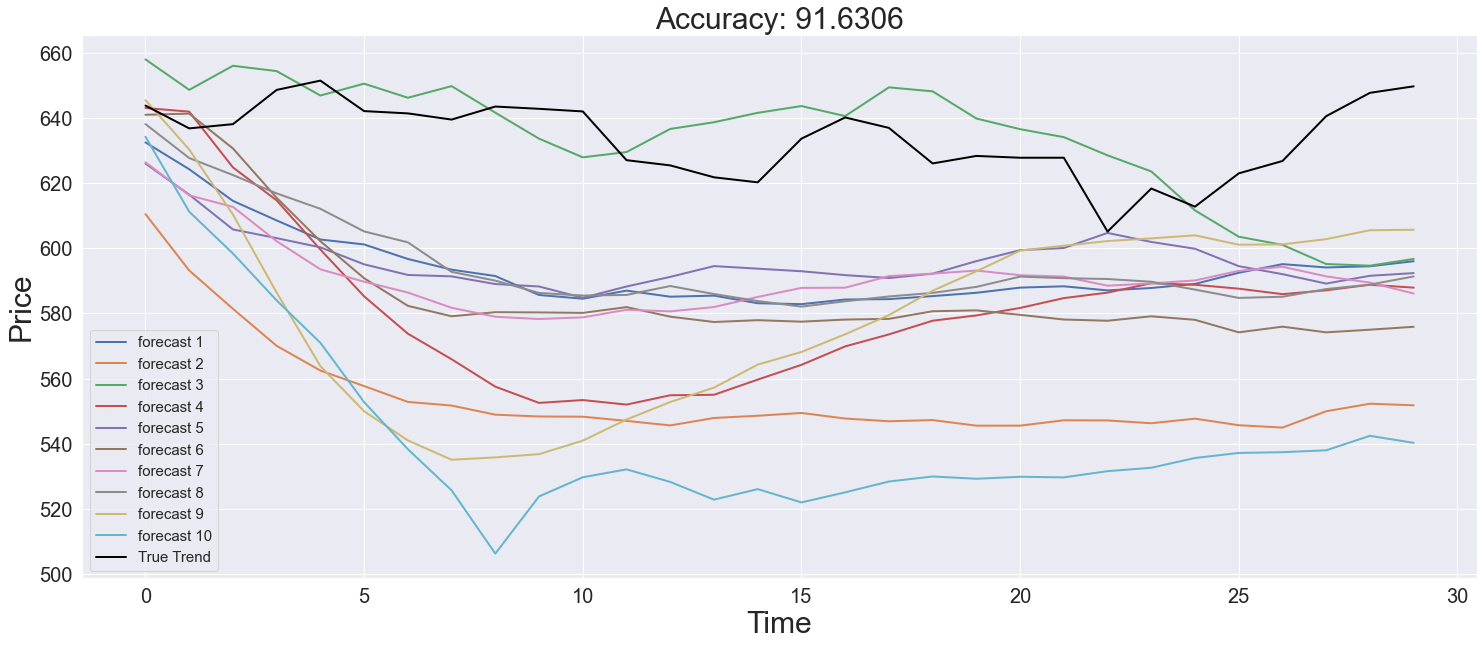

In [169]:
# Lets check the performance of model
accuracies = [calculate_accuracy(data['Close'].iloc[-test_size: ].values, d) for d in result7]

plt.figure(figsize=[25,10])
for no, d in enumerate(result7):
    plt.plot(d, label='forecast %d' %(no+1), linewidth=2)
plt.plot(data['Close'].iloc[-test_size: ].values, label='True Trend', c='black', linewidth=2)
plt.legend(fontsize=15)
plt.xlabel('Time', fontsize=30)
plt.ylabel('Price', fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('Accuracy: %.4f' %(np.mean(accuracies)), fontsize=30)
plt.show()

# 8) CNN SeqToSeq

In [219]:
# Define encoder block
def encoder_block(inp, n_hidden_layers, filter_size):
    inp = tf.expand_dims(inp, 2)
    
    inp = tf.pad(inp,
                    [[0,0],
                    [0,0],
                    [((filter_size[0]-1) // 2), ((filter_size[0]-1) // 2)],
                    [0,0]])
    
    conv = tf.compat.v1.layers.conv2d(inp, n_hidden_layers, filter_size, padding='VALID', activation=None)
    conv = conv[:, :, 0, :]
    return conv


# Similarly define a decoder block
def decoder_block(inp, n_hidden_layers, filter_size):
    inp = tf.expand_dims(inp, 2)
    
    inp = tf.pad(inp,
                    [[0,0],
                    [0,0],
                    [(filter_size[0] - 1), 0],
                    [0,0]])
    
    conv = tf.compat.v1.layers.conv2d(inp, n_hidden_layers, filter_size, padding='VALID', activation=None)
    conv = conv[:, :, 0, :]
    return conv



# Define an activation function GLU (Gated Linear Unit)
def glu(x):
    return tf.multiply(x[:, :, :tf.shape(x)[2] // 2], tf.sigmoid(x[:, :, tf.shape(x)[2] // 2 :]))
                       
                       
        
# Define a function layer to add layers in NN
def layer(inp, n_hidden_layers, filter_ht, conv_block, residual=None):
    z = conv_block(inp, n_hidden_layers, (filter_ht, 1))
    z_glu = glu(z)
    
    if residual is not None:
        # Pad the z_glu tensor to match the shape of the residual tensor along the second dimension
        z_glu = tf.pad(z_glu, [[0, 0], [1, 1], [0, 0]])  # Pad along the second dimension
        
        return z_glu + residual
    else:
        return z_glu



# Define models architecture
class Model8(tf.keras.Model):
    def __init__(self, learning_rate, cnn_cells_no, cnn_layers_no, input_feature_size, output_size, filter_size=3,
                no_attention_heads=16, dropout=0.9):
        
        super(Model8, self).__init__()
        
        self.X = tf.compat.v1.placeholder(tf.float32, (None, None, input_feature_size))
        self.y = tf.compat.v1.placeholder(tf.float32, (None, output_size))
        
        encoder_embedded = tf.compat.v1.layers.dense(self.X, cnn_cells_no) # I/p embed to high dim
        
        
        e = tf.identity(encoder_embedded)
        for i in range(cnn_layers_no):
            z = layer(encoder_embedded, cnn_cells_no*2, filter_size, encoder_block, encoder_embedded)
            z = tf.compat.v1.nn.dropout(z, rate=dropout)
            encoder_embedded = z  # Encoder Output
            
        encoder_output, output_memory = z, z+e
        g = tf.identity(encoder_embedded)
        
        
        for i in range(cnn_layers_no): # Decoder Output
            h = layer(encoder_embedded, cnn_cells_no*2, filter_size, decoder_block, tf.zeros_like(encoder_embedded))
            
            C = []
            for j in range(no_attention_heads):
                h_ = tf.compat.v1.layers.dense(h, cnn_cells_no//no_attention_heads)
                g_ = tf.compat.v1.layers.dense(g, cnn_cells_no//no_attention_heads)
                zu_ = tf.compat.v1.layers.dense(encoder_output, cnn_cells_no//no_attention_heads)
                ze_ = tf.compat.v1.layers.dense(output_memory, cnn_cells_no//no_attention_heads)
                d = tf.compat.v1.layers.dense(h_, cnn_cells_no//no_attention_heads) + g_
                dz = tf.matmul(d, tf.transpose(zu_, [0, 2, 1]))
                a = tf.compat.v1.nn.softmax(dz)
                c_ = tf.matmul(a, ze_)
                C.append(c_)
            
            c = tf.concat(C, 2)
            h = tf.compat.v1.layers.dense(h+c, cnn_cells_no)  # Combine the info
            h = tf.compat.v1.nn.dropout(h, rate=dropout)
            encoder_embedded = h
        
        
        encoder_embedded = tf.sigmoid(encoder_embedded[-1])
        self.logits = tf.compat.v1.layers.dense(encoder_embedded, output_size)
        self.cost = tf.reduce_mean(tf.square(self.y - self.logits))
        self.optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate).minimize(self.cost)
    
    
    
    
def calculate_accuracy(real, predicted):
    real = np.array(real)+1
    predicted = np.array(predicted)+1
    percentage = 1 - np.sqrt(np.mean(np.square((real-predicted)/real)))
    return percentage*100



def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = (last*weight) + ((1-weight)*i)
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer     

### The function encoder block takes inp tensor, no of hidden layers and filter size, expand the dimensions of inp tensor at axis 2, add symmetric padding to 2nd dimension and 0 padding for all other dimensions. The model conv2D is initialized with parameters. Unneccessary dimensions are removed using squeez. Similarly decoder block is created with asymmetric padding at 2nd dim. The activation function Gated Linear Unit is defined to multiply elementwise first half of input feature with 2nd half (values converted to probabilities) to selectively propogate info based on gating values. If a value in the gating vector is close to 1, it allows the corresponding value in the first half of the tensor to pass through unchanged. If it's close to 0, it suppresses the corresponding value. GLU controls the flow of information through the network and enabling it to learn complex patterns in sequential data. The function layer encapsulates a layer in a neural network, which consists of a convolutional block followed by a GLU activation function and an optional residual connection. For each layer of cnn cells a function layer applies encoder block to process the i/p and the ouput for each layer is stored in encoder embedded. Similarly, the decoder part is processed through the same number of layers and blocks. The loop is iterating over no of attention heads to calculate attention score using dense layer. Having multiple attention heads can increase the model's capacity to capture complex relationships, dependancies within the input data and can lead to better performance. Finally, the output is passed through a sigmoid activation and another dense layer to produce the logits.

In [220]:
learning_rate = 0.001
cnn_layers_no = 1
cnn_cells_no = 128
dropout_rate = 0.7
epoches = 300
timestamp = test_size

# Train the loop over specified no of epochs, make training in batches, update lstm model parameters through backpropogation 
# and record the loss and accuracy metrics for each epoch
def forecast8():

    tf.compat.v1.reset_default_graph()
    
    modelcnnseqtoseq = Model8(learning_rate, cnn_cells_no, cnn_layers_no, df.shape[1], df.shape[1], dropout=dropout_rate)
    
    sess = tf.compat.v1.InteractiveSession()
    sess.run(tf.compat.v1.global_variables_initializer())
    date_ori = pd.to_datetime(data.iloc[:, 0]).tolist()
    
    # Creating progress bar for the training loop that iterates over number of epoches 
    pbar = tqdm(range(epoches), desc = 'training_loop')
    for i in pbar:
        
        total_loss, total_acc = [], []
        for k in range(0, train_df.shape[0]-1, timestamp):
            last_index = min(k+timestamp, train_df.shape[0]-1)
            
            batch_X = np.expand_dims(train_df.iloc[k:last_index, :].values, axis=0)
           
            
            batch_y = train_df.iloc[k+1:last_index+1, :].values
            
            feed_dict = {
                modelcnnseqtoseq.X: batch_X,
                modelcnnseqtoseq.y: batch_y,
            }
            
            logits, gradients, loss = sess.run(
                [modelcnnseqtoseq.logits, modelcnnseqtoseq.optimizer, 
                 modelcnnseqtoseq.cost],
                feed_dict=feed_dict
            )
            
            
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:,0], logits[:,0]))
            
        pbar.set_postfix(cost=np.mean(total_loss), acc=np.mean(total_acc))
        
        
        
        
        
# Forecasting using trained lstm model on the batches of training data and also on remaining data points
    future_days = test_size
    output_prediction = np.zeros((train_df.shape[0]+future_days, train_df.shape[1]))
    output_prediction[0] = train_df.iloc[0]
    upper_bound = (train_df.shape[0] // timestamp)*timestamp
    
    
    for k in range(0, upper_bound, timestamp):
        
        output_logits = sess.run(
            [modelcnnseqtoseq.logits],
            feed_dict={
                modelcnnseqtoseq.X: np.expand_dims(
                    train_df.iloc[k: k + timestamp], axis=0
                )
            }
        )
        
       
        output_prediction[k+1: k+timestamp+1] = output_logits[0]
        
    if upper_bound != train_df.shape[0]:
        
        output_logits = sess.run(
            [modelcnnseqtoseq.logits],
            feed_dict={
                modelcnnseqtoseq.X: np.expand_dims(
                    train_df.iloc[upper_bound: ], axis=0
                )
            }
        )
        
        output_prediction[upper_bound+1: train_df.shape[0]+1] = output_logits[0]
        future_days -= 1
        date_ori.append(date_ori[-1] + timedelta(days=1))


    
    
    
# Forecasting for each of the future days to get output 
    for i in range(future_days):
        sliceo = output_prediction[-future_days - timestamp + i: -future_days + i]
       
        output_logits = sess.run(
            [modelcnnseqtoseq.logits],
            feed_dict={
                modelcnnseqtoseq.X: np.expand_dims(
                    sliceo, axis=0
                )
            }
        )
    
        
        for j, val in enumerate(output_logits[-1][0]):
            output_prediction[-future_days + i, j] = val
            
        date_ori.append(date_ori[-1] + timedelta(days=1))
        
        
    output_prediction = scaler.inverse_transform(output_prediction)
    future_pred = anchor(output_prediction[:,0], 0.3)
    
    return future_pred[-test_size: ]

In [221]:
# Run the simulation
result8 = []
for i in range(simulation):
    print('simulation %d' %(i+1))
    result8.append(forecast8())

simulation 1


training_loop: 100%|█████████████████████████████████████████| 300/300 [01:03<00:00,  4.73it/s, acc=95.2, cost=0.00488]


simulation 2


training_loop: 100%|█████████████████████████████████████████| 300/300 [00:31<00:00,  9.51it/s, acc=94.3, cost=0.00698]


simulation 3


training_loop: 100%|█████████████████████████████████████████| 300/300 [00:30<00:00,  9.83it/s, acc=94.3, cost=0.00676]


simulation 4


training_loop: 100%|███████████████████████████████████████████| 300/300 [00:32<00:00,  9.25it/s, acc=95, cost=0.00594]


simulation 5


training_loop: 100%|█████████████████████████████████████████| 300/300 [00:30<00:00,  9.74it/s, acc=95.3, cost=0.00471]


simulation 6


training_loop: 100%|██████████████████████████████████████████| 300/300 [00:30<00:00,  9.88it/s, acc=94.5, cost=0.0066]


simulation 7


training_loop: 100%|██████████████████████████████████████████| 300/300 [00:30<00:00,  9.73it/s, acc=94.5, cost=0.0061]


simulation 8


training_loop: 100%|█████████████████████████████████████████| 300/300 [00:30<00:00,  9.86it/s, acc=95.6, cost=0.00413]


simulation 9


training_loop: 100%|█████████████████████████████████████████| 300/300 [00:33<00:00,  9.03it/s, acc=94.9, cost=0.00617]


simulation 10


training_loop: 100%|█████████████████████████████████████████| 300/300 [00:30<00:00,  9.89it/s, acc=95.2, cost=0.00505]


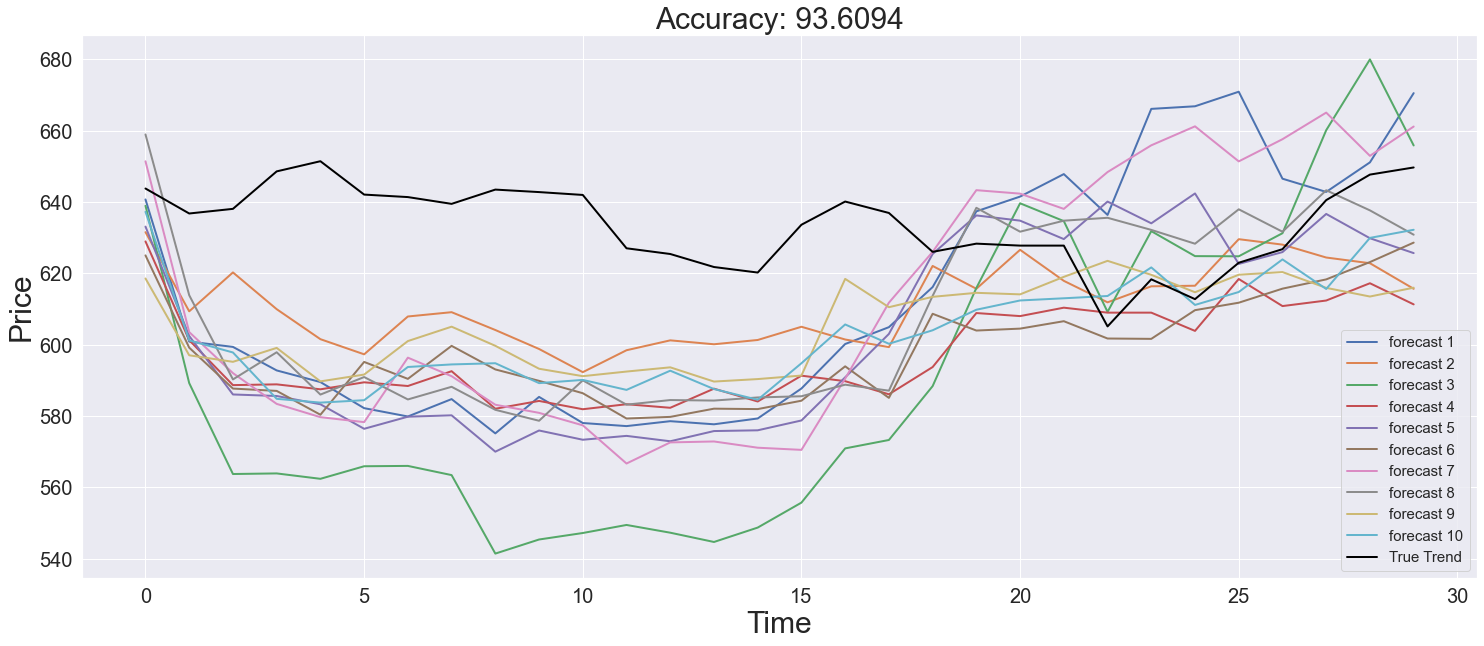

In [222]:
# Lets check the performance of model
accuracies = [calculate_accuracy(data['Close'].iloc[-test_size: ].values, f) for f in result8]

plt.figure(figsize=[25,10])
for no, f in enumerate(result8):
    plt.plot(f, label='forecast %d' %(no+1), linewidth=2)
plt.plot(data['Close'].iloc[-test_size: ].values, label='True Trend', c='black', linewidth=2)
plt.legend(fontsize=15)
plt.xlabel('Time', fontsize=30)
plt.ylabel('Price', fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('Accuracy: %.4f' %(np.mean(accuracies)), fontsize=30)
plt.show()

# 9) Dilated CNN SeqToSeq (Transformer Arch.)

In [275]:
# Building positional encoding fun
def positional_encoding(inputs):
    sec_dim = tf.shape(inputs)[1]        # Sequence length 2nd dim of i/p
    retreiv_dim = inputs.get_shape()[-1]   # Retreive the last dim's value of input vector
    position = tf.reshape(tf.range(0.0, tf.compat.v1.to_float(sec_dim), dtype=tf.float32), [-1,1])  # Column vector
    i = np.arange(0, retreiv_dim, 2, dtype=np.float32)
    denominator = np.reshape(np.power(10000.0, i/retreiv_dim), [1,-1])  # Row vector
    
    encoder = tf.reshape(tf.concat([tf.sin(position/denominator), tf.cos(position/denominator)], 1), 
                         [-1, sec_dim, retreiv_dim]) # Exponential scaling
    
    return tf.tile(encoder, [tf.shape(inputs)[0], 1, 1]) # Tiled to batch dim to match the batch size of input


# Building layer_norm fun for stabilized training and faster convergence
def layer_normalization(inputs, epsilon=1e-8):
    mean, varience = tf.compat.v1.nn.moments(inputs, [-1], keep_dims=True) # mean & var along last dim of i/p tensor
    normalized = (inputs - mean)/(tf.sqrt(varience + epsilon))  # Normalized input tensor using mean and var
    param_shape = inputs.get_shape()[-1:] # Last dim's shape ie i/p features, channels
    gamma = tf.compat.v1.get_variable('gamma', param_shape, tf.float32, tf.ones_initializer()) # Trainable param
    beta = tf.compat.v1.get_variable('beta', param_shape, tf.float32, tf.zeros_initializer())  # Trainable param
    return gamma*normalized + beta


# Build a 1D conv block
def conv_block(x, hidden_dim, pad_size, filter_size, dilation_rate):
    x = layer_normalization(x)
    pad = tf.zeros([tf.shape(x)[0], pad_size, hidden_dim])
    x = tf.compat.v1.layers.conv1d(inputs=tf.concat([pad, x, pad], 1),
                                  filters=hidden_dim,
                                  kernel_size=filter_size,
                                  dilation_rate=dilation_rate)
    x = x[:, :-pad_size, :]
    x = tf.compat.v1.nn.relu(x)
    return x


# Build the model architecture
class Model9(tf.keras.Model):
    
    def __init__(self, learning_rate, cnn_cells_no, cnn_layers_no, input_feature_size, output_size, filter_size=3,
                no_attension_heads=16, dropout=0.9):
        
        super(Model9, self).__init__()
        
        self.X = tf.compat.v1.placeholder(tf.float32, (None, None, input_feature_size))
        self.y = tf.compat.v1.placeholder(tf.float32, (None, output_size))
        
        encoder_embedded = tf.compat.v1.layers.dense(self.X, cnn_cells_no)
        encoder_embedded += positional_encoding(encoder_embedded)
        
        e = tf.identity(encoder_embedded)
        for i in range(cnn_layers_no):
            dilation_rate = 2**i
            pad_size = (filter_size - 1)*dilation_rate
            with tf.compat.v1.variable_scope('encode_%d' %i):
                encoder_embedded += conv_block(encoder_embedded, cnn_cells_no, pad_size, filter_size, dilation_rate)
                
        encoder_output, output_memory = encoder_embedded, encoder_embedded + e
        g = tf.identity(encoder_embedded) # How attension is applied to i/p seq for during decoding 
        
        
        for i in range(cnn_layers_no):
            dilation_rate = 2**i
            pad_size = (filter_size - 1)*dilation_rate
            with tf.compat.v1.variable_scope('decode_%d' %i):
                h = conv_block(encoder_embedded, cnn_cells_no, pad_size, filter_size, dilation_rate)
                
            C = []
            for j in range(no_attension_heads):
                h_ = tf.compat.v1.layers.dense(h, cnn_cells_no//no_attension_heads) # Transformed decoder output
                g_ = tf.compat.v1.layers.dense(g, cnn_cells_no//no_attension_heads) # Transformed/modified Gate signal for specific att head
                zu_ = tf.compat.v1.layers.dense(encoder_output, cnn_cells_no//no_attension_heads)
                ze_ = tf.compat.v1.layers.dense(output_memory, cnn_cells_no//no_attension_heads) # Value vector used for weighted sum
            
                d = tf.compat.v1.layers.dense(h_, cnn_cells_no//no_attension_heads) + g_ #combines the transformed input 
                # representation (h_) with the transformed gate signal (g_) 
                # to create an interaction between the input sequences and the gate signal for this attention head
            
                dz = tf.matmul(d, tf.transpose(zu_, [0,2,1])) # The result is a set of attention scores that represent 
                # the relevance of each input sequence element to the current attention head.
            
                a = tf.compat.v1.nn.softmax(dz)  # Attention score
            
                c_ = tf.matmul(a, ze_) # weighted sum of the value vectors, where each value vector is weighted 
                # by its corresponding attention score.
            
                C.append(c_) # Context vectors
            
            c = tf.concat(C, 2)
            h = tf.compat.v1.layers.dense(h+c, cnn_cells_no)
            h = tf.compat.v1.layers.dropout(h, rate=dropout)
            encoder_embedded += h
        
        encoder_embedded = tf.sigmoid(encoder_embedded[-1])
        self.logits = tf.compat.v1.layers.dense(encoder_embedded, output_size)
        self.cost = tf.reduce_mean(tf.square(self.y - self.logits))
        self.optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate).minimize(self.cost)
        
    
    
        
def calculate_accuracy(real, predicted):
    real = np.array(real)+1
    predicted = np.array(predicted)+1
    percentage = 1 - np.sqrt(np.mean(np.square((real-predicted)/real)))
    return percentage*100



def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = (last*weight) + ((1-weight)*i)
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

### The function positional encoding is used to inject the positional info into input embeddings (Transformer arch). The transformer does'nt know the order of tokens/elements in seq inherently. The combination of sin and cosine fun creates unique positional encodings for each position in i/p seq. The frequency of sin and cosine fun are determined by dividing the position by denominator (exp factor). This ensures each dim of position encodings captures info about diff freq of position. Finally, the sine and cosine positional encodings are concatenated along the last dimension to form the final encoding for each position. This encoding is then tiled along the batch dimension to match the batch size of the input data.

### This code block uses the layer norm to stabilize the training process and for faster convergence. The mean and varience of i/p tensor along its last dim is calculated and their dims are kept consistent with input. The trainable params gamma and beta are initialized with ones and zeroes with shapes equal to shape of i/p features. Scaling and shifting operation allows the model to learn an optimal scale and shift for each feature/channel, effectively normalizing the activations of each layer.

### The cnn block applies layer normalization to the input x. Layer normalization normalizes the activations of the previous layer for each sample in a mini-batch independently, so that they have a mean of zero and a standard deviation of one. This helps stabilize the training process. The pad creates zero tensor having shape [batch_size, pad_size, hidden_dim]. Padding is added to both sides of the input tensor x to ensure that the convolution operation maintains the same length of the input sequence. The 1D conv operation is performed on i/p tensor. The OG i/p tensor is concatenated with padded tensor along its second dim ie time steps/seq length. The convolution operation applies a set of filters to the input tensor to produce a feature map. The dilation rate controls how the filters are applied across the input sequence. Padding is removed from the output tensor x along the second dimension, keeping only the relevant part of the output. This step ensures that the output tensor has the same length as the input tensor. ReLU (Rectified Linear Unit) activation function is applied element-wise to the output tensor x.

### The model architecture with dilated conv and attension mechanism is created. The encoder and decoder processes the input sequences through a stack of dilated convolutional blocks. Within each block, multiple attention heads are employed to capture different aspects of the input sequences' context. For each attention head, the input sequences are transformed using separate dense layers to learn different representations or aspects of the input sequences' context.

In [276]:
learning_rate = 5e-4
cnn_layers_no = 1
cnn_cells_no = 128
dropout_rate = 0.8
epoches = 300
timestamp = test_size

# Train the loop over specified no of epochs, make training in batches, update lstm model parameters through backpropogation 
# and record the loss and accuracy metrics for each epoch
def forecast9():

    tf.compat.v1.reset_default_graph()
    
    modelcnnseqtoseq_dil = Model9(learning_rate, cnn_cells_no, cnn_layers_no, df.shape[1], df.shape[1], dropout=dropout_rate)
    
    sess = tf.compat.v1.InteractiveSession()
    sess.run(tf.compat.v1.global_variables_initializer())
    date_ori = pd.to_datetime(data.iloc[:, 0]).tolist()
    
    # Creating progress bar for the training loop that iterates over number of epoches 
    pbar = tqdm(range(epoches), desc = 'training_loop')
    for i in pbar:
        
        total_loss, total_acc = [], []
        for k in range(0, train_df.shape[0]-1, timestamp):
            last_index = min(k+timestamp, train_df.shape[0]-1)
            
            batch_X = np.expand_dims(train_df.iloc[k:last_index, :].values, axis=0)
           
            
            batch_y = train_df.iloc[k+1:last_index+1, :].values
            
            feed_dict = {
                modelcnnseqtoseq_dil.X: batch_X,
                modelcnnseqtoseq_dil.y: batch_y,
            }
            
            logits, gradients, loss = sess.run(
                [modelcnnseqtoseq_dil.logits, modelcnnseqtoseq_dil.optimizer, 
                 modelcnnseqtoseq_dil.cost],
                feed_dict=feed_dict
            )
            
            
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:,0], logits[:,0]))
            
        pbar.set_postfix(cost=np.mean(total_loss), acc=np.mean(total_acc))
        
        
        
        
        
# Forecasting using trained lstm model on the batches of training data and also on remaining data points
    future_days = test_size
    output_prediction = np.zeros((train_df.shape[0]+future_days, train_df.shape[1]))
    output_prediction[0] = train_df.iloc[0]
    upper_bound = (train_df.shape[0] // timestamp)*timestamp
    
    
    for k in range(0, upper_bound, timestamp):
        
        output_logits = sess.run(
            [modelcnnseqtoseq_dil.logits],
            feed_dict={
                modelcnnseqtoseq_dil.X: np.expand_dims(
                    train_df.iloc[k: k + timestamp], axis=0
                )
            }
        )
        
       
        output_prediction[k+1: k+timestamp+1] = output_logits[0]
        
    if upper_bound != train_df.shape[0]:
        
        output_logits = sess.run(
            [modelcnnseqtoseq_dil.logits],
            feed_dict={
                modelcnnseqtoseq_dil.X: np.expand_dims(
                    train_df.iloc[upper_bound: ], axis=0
                )
            }
        )
        
        output_prediction[upper_bound+1: train_df.shape[0]+1] = output_logits[0]
        future_days -= 1
        date_ori.append(date_ori[-1] + timedelta(days=1))


    
    
    
# Forecasting for each of the future days to get output 
    for i in range(future_days):
        sliceo = output_prediction[-future_days - timestamp + i: -future_days + i]
       
        output_logits = sess.run(
            [modelcnnseqtoseq_dil.logits],
            feed_dict={
                modelcnnseqtoseq_dil.X: np.expand_dims(
                    sliceo, axis=0
                )
            }
        )
    
        
        
        for j, val in enumerate(output_logits[-1][0]):
            output_prediction[-future_days + i, j] = val
            
        date_ori.append(date_ori[-1] + timedelta(days=1))
        
        
    output_prediction = scaler.inverse_transform(output_prediction)
    future_pred = anchor(output_prediction[:,0], 0.3)
    
    return future_pred[-test_size: ]

In [277]:
# Run the simulation
result9 = []
for i in range(simulation):
    print('simulation %d' %(i+1))
    result9.append(forecast9())

simulation 1


training_loop: 100%|████████████████████████████████████████| 300/300 [00:26<00:00, 11.38it/s, acc=98.3, cost=0.000673]


simulation 2


training_loop: 100%|████████████████████████████████████████| 300/300 [00:25<00:00, 11.61it/s, acc=97.9, cost=0.000995]


simulation 3


training_loop: 100%|█████████████████████████████████████████| 300/300 [00:26<00:00, 11.14it/s, acc=97.9, cost=0.00106]


simulation 4


training_loop: 100%|█████████████████████████████████████████| 300/300 [00:25<00:00, 11.80it/s, acc=97.3, cost=0.00161]


simulation 5


training_loop: 100%|█████████████████████████████████████████| 300/300 [00:26<00:00, 11.43it/s, acc=96.5, cost=0.00262]


simulation 6


training_loop: 100%|█████████████████████████████████████████| 300/300 [00:28<00:00, 10.44it/s, acc=97.1, cost=0.00184]


simulation 7


training_loop: 100%|███████████████████████████████████████████| 300/300 [00:27<00:00, 10.87it/s, acc=97, cost=0.00197]


simulation 8


training_loop: 100%|████████████████████████████████████████| 300/300 [00:30<00:00,  9.75it/s, acc=98.4, cost=0.000579]


simulation 9


training_loop: 100%|█████████████████████████████████████████| 300/300 [00:30<00:00,  9.93it/s, acc=97.1, cost=0.00177]


simulation 10


training_loop: 100%|█████████████████████████████████████████| 300/300 [00:30<00:00,  9.85it/s, acc=97.3, cost=0.00152]


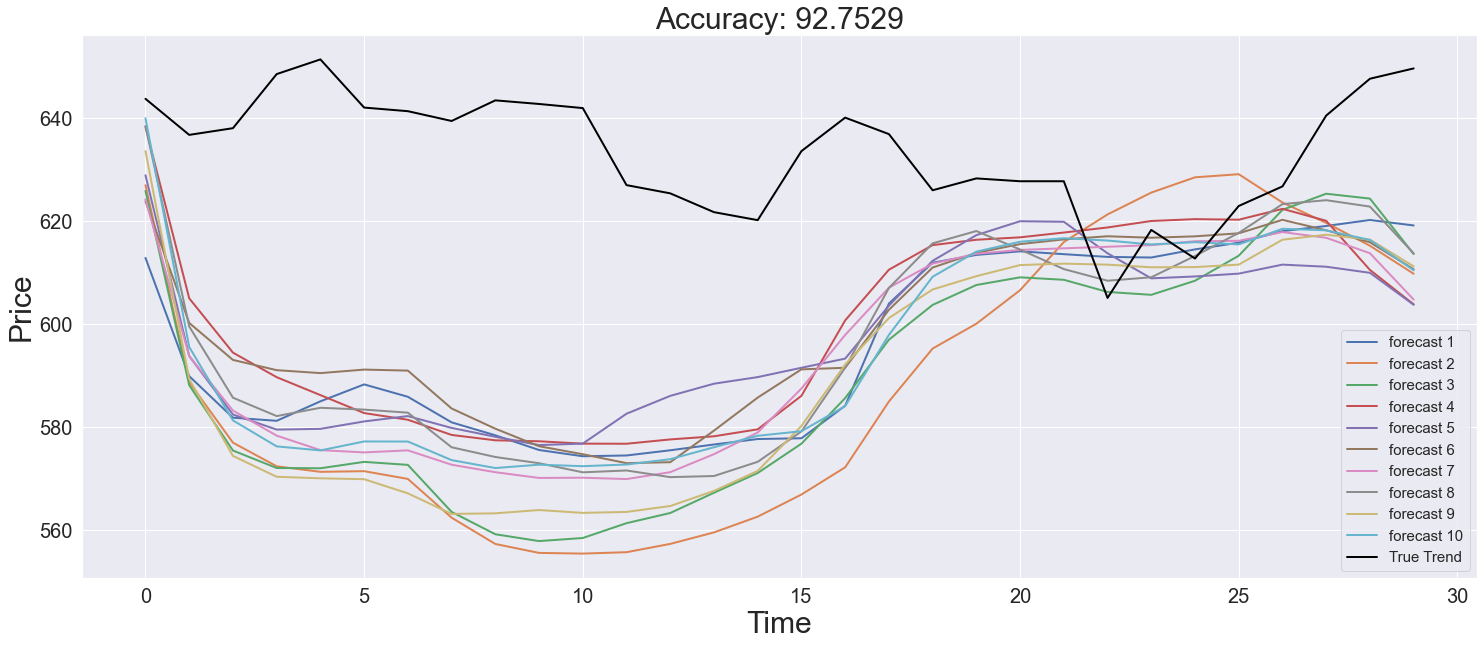

In [278]:
# Lets check the performance of model
accuracies = [calculate_accuracy(data['Close'].iloc[-test_size: ].values, k) for k in result9]

plt.figure(figsize=[25,10])
for no, k in enumerate(result9):
    plt.plot(k, label='forecast %d' %(no+1), linewidth=2)
plt.plot(data['Close'].iloc[-test_size: ].values, label='True Trend', c='black', linewidth=2)
plt.legend(fontsize=15)
plt.xlabel('Time', fontsize=30)
plt.ylabel('Price', fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('Accuracy: %.4f' %(np.mean(accuracies)), fontsize=30)
plt.show()

# 10) Multihead Attention Mechanism

In [309]:
# Building layer normalization fun to normalize the activations of prev layers
def layer_norm(inputs, epsilon=1e-8):
    mean, varience = tf.compat.v1.nn.moments(inputs, [-1], keep_dims=True)
    normalized = (inputs - mean) / (tf.sqrt(varience + epsilon))
    params_shape = inputs.get_shape()[-1:]
    gamma = tf.compat.v1.get_variable('gamma', params_shape, tf.float32, tf.ones_initializer())
    beta = tf.compat.v1.get_variable('beta', params_shape, tf.float32, tf.zeros_initializer())
    output = normalized * gamma + beta
    return output



# Defining Multihead attention mech
def multihead_attention(queries, keys, q_masks, k_masks, num_units, num_heads, future_binding):
    T_q = tf.shape(queries)[1]
    T_k = tf.shape(keys)[1]
    
    Q = tf.compat.v1.layers.dense(queries, num_units, name='Q')    # num_units = Dimensionality of query, key and value vector
    K_V = tf.compat.v1.layers.dense(keys, 2*num_units, name='K_V')
    
    K, V = tf.split(K_V, 2, -1)
    
    Q_ = tf.concat(tf.split(Q, num_heads, axis=2), axis=0)
    K_ = tf.concat(tf.split(K, num_heads, axis=2), axis=0)
    V_ = tf.concat(tf.split(V, num_heads, axis=2), axis=0)
    
    align_mat = tf.matmul(Q_, tf.transpose(K_, [0,2,1]))  # Attention score matrix
    align_mat = align_mat / tf.sqrt(tf.cast(tf.shape(K_)[-1], dtype=tf.float32))
    
    paddings = tf.fill(tf.shape(align_mat), float('-inf'))
    
    key_masks = k_masks
    key_masks = tf.tile(key_masks, [num_heads, 1])
    key_masks = tf.tile(tf.expand_dims(key_masks, 1), [1, T_q, 1])
    align_mat = tf.where(tf.equal(key_masks, 0), paddings, align_mat)
    
    if future_binding:
        matrix = tf.ones([T_q, T_k])
        lower_rank_mat = tf.linalg.LinearOperatorLowerTriangular(matrix).to_dense()
        masks = tf.tile(tf.expand_dims(lower_rank_mat, 0), [tf.shape(align_mat)[0], 1, 1])
        align_mat = tf.where(tf.equal(masks, 0), paddings, align_mat)
        
    align_mat = tf.compat.v1.nn.softmax(align_mat)  # Attention wts
    query_masks = tf.compat.v1.to_float(q_masks)
    query_masks = tf.tile(query_masks, [num_heads, 1])
    query_masks = tf.tile(tf.expand_dims(query_masks, -1), [1, 1, T_k])
    align_mat *= query_masks
    
    outputs = tf.matmul(align_mat, V_)
    outputs = tf.concat(tf.split(outputs, num_heads, 0), axis=2)
    outputs += queries
    outputs = layer_norm(outputs)
    return outputs



# Define feed forward nn along with residual connection and layer norm
def feed_forward(inputs, hidden_units, activation=None):
    outputs = tf.compat.v1.layers.dense(inputs, 4*hidden_units, activation=activation)
    outputs = tf.compat.v1.layers.dense(outputs, hidden_units, activation=None)
    outputs += inputs
    outputs = layer_norm(outputs)
    return outputs



# Define position encoding fun 
def learned_pos_encoding(inputs, mask, embedd_dim):   # mask = Indicating valid positions input seq
    T = tf.shape(inputs)[1]                           # embedd_dim = dimensionality of the positional embeddings
    pos = tf.range(T)                       # (T_q)
    outputs = tf.expand_dims(pos, 0)        # (1, T_q)
    
    outputs = tf.tile(outputs, [tf.shape(inputs)[0], 1, 1])  # (N, T_q)
    outputs = embed_seq(outputs, T, embedd_dim, zero_pad=False, scale=False)
    return tf.expand_dims(tf.compat.v1.to_float(mask), -1)*outputs



# Define sinusoidal position encoding fun
def sinusoidal_pos_encoding(inputs, mask, retrieve_dim):    # retrieve_dim = embedd_dim
    T = tf.shape(inputs)[1]
    pos = tf.reshape(tf.range(0.0, tf.compat.v1.to_float(T), dtype=tf.float32), [-1,1])
    i = np.arange(0, retrieve_dim, 2, dtype=np.float32)
    denominator = tf.reshape(np.power(10000.0, i/retrieve_dim), [1,-1])
    encoder = tf.expand_dims(tf.concat([tf.sin(pos/denominator), tf.cos(pos/denominator)], 1), 0)
    return tf.tile(encoder, [tf.shape(inputs)[0], 1, 1]) * tf.expand_dims(tf.compat.v1.to_float(mask), -1)



# Define label smoothing fun
def label_smoothing(inputs, epsilon=0.1):    # Regularization tech to reduce overfitting
    C = inputs.get_shape().as_list()[-1]     # No of classes 
    return (((1-epsilon)*inputs) + (epsilon/C))



# Define the model architecture
class Attention(tf.keras.Model):
    
    def __init__(self, learning_rate, cells_no, embedded_size, input_feature_size, output_size, 
                num_blocks=2, num_heads=8, min_feq=50):
        
        super(Attention, self).__init__()
        
        self.X = tf.compat.v1.placeholder(tf.float32, (None, None, input_feature_size))    
        self.y = tf.compat.v1.placeholder(tf.float32, (None, output_size))
        
        encoder_embedded = tf.compat.v1.layers.dense(self.X, embedded_size)
        encoder_embedded = tf.compat.v1.layers.dropout(encoder_embedded, rate=0.8)
        
        x_mean = tf.reduce_mean(self.X, axis=2) # Mean pooling operation applied to the input data 
        # along the feature dimension to generate masks for the input.
        
        en_masks = tf.sign(x_mean)
        encoder_embedded += sinusoidal_pos_encoding(self.X, en_masks, embedded_size)
        
        for i in range(num_blocks):  # Multiple encoder blocks
            with tf.compat.v1.variable_scope('encoder_self_attention_%d' %i, reuse=tf.compat.v1.AUTO_REUSE):
                encoder_embedded = multihead_attention(queries=encoder_embedded, keys=encoder_embedded,
                                                      q_masks=en_masks, k_masks=en_masks, num_units=cells_no, 
                                                       num_heads=num_heads, future_binding=False)
                
                
            # Each block consists of self-attention followed by feedforward layers.    
                
            with tf.compat.v1.variable_scope('encoder_feedforward_%d' %i, reuse=tf.compat.v1.AUTO_REUSE):
                encoder_embedded = feed_forward(encoder_embedded, embedded_size, tf.compat.v1.nn.relu)
                
                
        self.logits = tf.compat.v1.layers.dense(encoder_embedded[:,-1], output_size)
        self.cost = tf.reduce_mean(tf.square(self.y - self.logits))
        self.optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate).minimize(self.cost)
        
        
        
def calculate_accuracy(real, predicted):
    real = np.array(real)+1
    predicted = np.array(predicted)+1
    percentage = 1 - np.sqrt(np.mean(np.square((real-predicted)/real)))
    return percentage*100



def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = (last*weight) + ((1-weight)*i)
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

### Layer normalization normalizes the inputs along the feature dimension, making the network more robust to variations in input distribution and accelerating training convergence.

### The multihead attention fun takes several inputs. The query and key tensors are projected to multiple heads using dense layer. The projected query, key, and value tensors are split along the feature dimension into num_heads separate tensors. This step separates the attention mechanism into multiple heads, allowing each head to focus on different parts of the input. The attention score matrix (align_matrix) is dot product of query and key tensors. The values of score matrix is scaled by dividing the matrix by sqrt of dimension of key vectors. The attention score matrix is masked using the provided key masks to prevent attending future tokens. If future_binding is enabled, a lower triangular matrix is used as a mask to enforce causal attention. The masked attention scores are passed through a softmax function to obtain attention weights. These weights are then multiplied by the value tensors to compute the weighted sum of values for each head. The resulting outputs are concatenated along the feature dimension and added to the original queries before passing through layer normalization.

### The function implements a feed-forward neural network (FFNN) layer with residual connection and layer normalization. The input tensor is projected to high dimensional space using dense layer. The output from first dense layer passed through second dense layer to project it to no of hidden units. The output of the second dense layer is added to the original inputs tensor. This implements a residual connection, allowing the model to learn residual mappings. Function generates learned positional encodings for each position in the input sequence and applies a mask to handle variable-length sequences or masked positions.

### Function generates sinusoidal positional encodings for each position in the input sequence based on the position indices. The encoding captures positional information using sine and cosine functions, with the frequency of oscillation decreasing as the position index increases. The encodings are scaled by the mask tensor to handle variable-length sequences or masked positions. Learned embeddings can capture fine-grained positional information tailored to the specific task, while sinusoidal encodings provide a more general, continuous representation of position that can help with generalization and interpolation. This combination may lead to improved performance and robustness.

### Label smoothing function adjusts the logits produced by the model during training by redistributing a small amount of confidence from the true class to other classes, helping to prevent overfitting and improve generalization performance. The output of the function is the smoothed logits, which are typically passed through a softmax activation function before being used to compute the loss during training.

### Attention class defines an attention-based model architecture with multiple encoder blocks, each consisting of self-attention and feedforward layers. 

In [310]:
learning_rate = 0.001
layers_no = 1
cells_no = 128
dropout_rate = 0.8
epoches = 300
timestamp = 5

# Train the loop over specified no of epochs, make training in batches, update lstm model parameters through backpropogation 
# and record the loss and accuracy metrics for each epoch
def forecast10():

    tf.compat.v1.reset_default_graph()
    
    model_attention = Attention(learning_rate, cells_no, cells_no, df.shape[1], df.shape[1])
    
    sess = tf.compat.v1.InteractiveSession()
    sess.run(tf.compat.v1.global_variables_initializer())
    date_ori = pd.to_datetime(data.iloc[:, 0]).tolist()
    
# Creating progress bar for the training loop that iterates over number of epoches 
    pbar = tqdm(range(epoches), desc = 'training_loop')
    for i in pbar:
        
        total_loss, total_acc = [], []
        for k in range(0, train_df.shape[0]-1, timestamp):
            last_index = min(k+timestamp, train_df.shape[0]-1)
            
            batch_X = np.expand_dims(train_df.iloc[k:last_index, :].values, axis=0)
           
            
            batch_y = train_df.iloc[k+1:last_index+1, :].values
            
            feed_dict = {
                model_attention.X: batch_X,
                model_attention.y: batch_y,
            }
            
            logits, gradients, loss = sess.run(
                [model_attention.logits, model_attention.optimizer, 
                 model_attention.cost],
                feed_dict=feed_dict
            )
            
            
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:,0], logits[:,0]))
            
        pbar.set_postfix(cost=np.mean(total_loss), acc=np.mean(total_acc))
        
        
        
        
        
# Forecasting using trained lstm model on the batches of training data and also on remaining data points
    future_days = test_size
    output_prediction = np.zeros((train_df.shape[0]+future_days, train_df.shape[1]))
    output_prediction[0] = train_df.iloc[0]
    upper_bound = (train_df.shape[0] // timestamp)*timestamp
    
    
    for k in range(0, upper_bound, timestamp):
        
        output_logits = sess.run(
            [model_attention.logits],
            feed_dict={
                model_attention.X: np.expand_dims(
                    train_df.iloc[k: k + timestamp], axis=0
                )
            }
        )
        
       
        output_prediction[k+1: k+timestamp+1] = output_logits[0]
        
    if upper_bound != train_df.shape[0]:
        
        output_logits = sess.run(
            [model_attention.logits],
            feed_dict={
                model_attention.X: np.expand_dims(
                    train_df.iloc[upper_bound: ], axis=0
                )
            }
        )
        
        output_prediction[upper_bound+1: train_df.shape[0]+1] = output_logits[0]
        future_days -= 1
        date_ori.append(date_ori[-1] + timedelta(days=1))


    
    
    
# Forecasting for each of the future days to get output 
    for i in range(future_days):
        sliceo = output_prediction[-future_days - timestamp + i: -future_days + i]
       
        output_logits = sess.run(
            [model_attention.logits],
            feed_dict={
                model_attention.X: np.expand_dims(
                    sliceo, axis=0
                )
            }
        )
    
        
        
        for j, val in enumerate(output_logits[-1][0]):
            output_prediction[-future_days + i, j] = val
            
        date_ori.append(date_ori[-1] + timedelta(days=1))
        
        
    output_prediction = scaler.inverse_transform(output_prediction)
    future_pred = anchor(output_prediction[:,0], 0.3)
    
    return future_pred[-test_size: ]

In [311]:
# Run the simulation
result10 = []
for i in range(simulation):
    print('simulation %d' %(i+1))
    result10.append(forecast10())

simulation 1


training_loop: 100%|█████████████████████████████████████████| 300/300 [01:40<00:00,  2.97it/s, acc=96.7, cost=0.00289]


simulation 2


training_loop: 100%|█████████████████████████████████████████| 300/300 [01:31<00:00,  3.29it/s, acc=94.8, cost=0.00713]


simulation 3


training_loop: 100%|█████████████████████████████████████████| 300/300 [01:29<00:00,  3.34it/s, acc=96.7, cost=0.00285]


simulation 4


training_loop: 100%|█████████████████████████████████████████| 300/300 [01:29<00:00,  3.36it/s, acc=96.7, cost=0.00284]


simulation 5


training_loop: 100%|█████████████████████████████████████████| 300/300 [01:29<00:00,  3.35it/s, acc=94.4, cost=0.00715]


simulation 6


training_loop: 100%|█████████████████████████████████████████| 300/300 [01:32<00:00,  3.24it/s, acc=96.7, cost=0.00289]


simulation 7


training_loop: 100%|█████████████████████████████████████████| 300/300 [01:28<00:00,  3.40it/s, acc=95.6, cost=0.00493]


simulation 8


training_loop: 100%|█████████████████████████████████████████| 300/300 [01:28<00:00,  3.39it/s, acc=96.7, cost=0.00291]


simulation 9


training_loop: 100%|██████████████████████████████████████████| 300/300 [01:32<00:00,  3.23it/s, acc=91.9, cost=0.0152]


simulation 10


training_loop: 100%|█████████████████████████████████████████| 300/300 [01:28<00:00,  3.38it/s, acc=96.1, cost=0.00381]


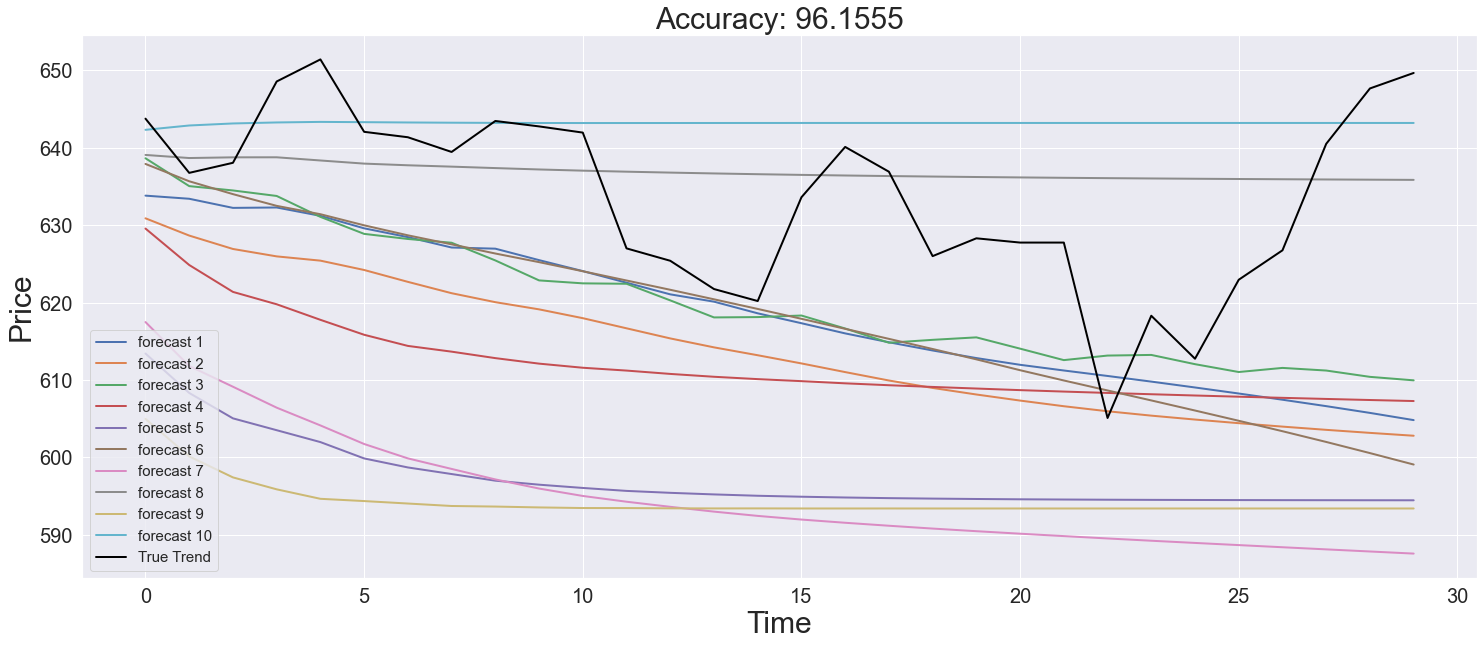

In [312]:
# Lets check the performance of model
accuracies = [calculate_accuracy(data['Close'].iloc[-test_size: ].values, w) for w in result10]

plt.figure(figsize=[25,10])
for no, w in enumerate(result10):
    plt.plot(w, label='forecast %d' %(no+1), linewidth=2)
plt.plot(data['Close'].iloc[-test_size: ].values, label='True Trend', c='black', linewidth=2)
plt.legend(fontsize=15)
plt.xlabel('Time', fontsize=30)
plt.ylabel('Price', fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('Accuracy: %.4f' %(np.mean(accuracies)), fontsize=30)
plt.show()

# 11) Autoencoder-Ensemble-XGB

In [278]:
# Scaling the data using minmax scaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler().fit(data.iloc[:, 4].values.reshape((-1,1)))
close_normalized = scaler.transform(data.iloc[:, 4].values.reshape((-1,1))).reshape((-1))
close_normalized.shape

(254,)

In [279]:
import time
# Create class Autoencoder to reduce dimension of input data, to learn imp features and to remove noise
class autoencoder:
    def __init__(self, input_, dimensions=2, learning_rate=0.01, hidden_layer=256, epochs=20):
        input_size = input_.shape[1]    # No of features
        self.X = tf.compat.v1.placeholder('float', [None, input_size])
        
        weights = {
            'encoder h1':tf.compat.v1.Variable(tf.compat.v1.random_normal([input_size, hidden_layer])), # I/P to 1st Hidden
            'encoder h2':tf.compat.v1.Variable(tf.compat.v1.random_normal([hidden_layer, dimensions])), # 1st Hidden to Latent space
            'decoder h1':tf.compat.v1.Variable(tf.compat.v1.random_normal([dimensions, hidden_layer])), # LS to 2nd Hidden
            'decoder h2':tf.compat.v1.Variable(tf.compat.v1.random_normal([hidden_layer, input_size])) # 2nd Hidden to O/P
        }
        
        baises = {
            'encoder b1':tf.compat.v1.Variable(tf.compat.v1.random_normal([hidden_layer])), # I/P to 1st Hidden
            'encoder b2':tf.compat.v1.Variable(tf.compat.v1.random_normal([dimensions])), # 1st Hidden to Latent space
            'decoder b1':tf.compat.v1.Variable(tf.compat.v1.random_normal([hidden_layer])), # LS to 2nd Hidden
            'decoder b2':tf.compat.v1.Variable(tf.compat.v1.random_normal([input_size])) # 2nd Hidden to O/P
        }
        
        first_layer_encoder = tf.compat.v1.nn.sigmoid(tf.add(tf.matmul(self.X, weights['encoder h1']), baises['encoder b1']))
        self.second_layer_encoder = tf.compat.v1.nn.sigmoid(tf.add(tf.matmul(first_layer_encoder, weights['encoder h2']), baises['encoder b2']))
        first_layer_decoder = tf.compat.v1.nn.sigmoid(tf.add(tf.matmul(self.second_layer_encoder, weights['decoder h1']), baises['decoder b1']))
        second_layer_decoder = tf.compat.v1.nn.sigmoid(tf.add(tf.matmul(first_layer_decoder, weights['decoder h2']), baises['decoder b2']))
        self.cost = tf.reduce_mean(tf.pow(self.X - second_layer_decoder, 2))
        self.optimizer = tf.compat.v1.train.RMSPropOptimizer(learning_rate).minimize(self.cost)
        self.sess = tf.compat.v1.InteractiveSession()
        self.sess.run(tf.compat.v1.global_variables_initializer())
        
        for i in range(epochs):
            start_time = time.perf_counter()
            gradients, loss = self.sess.run([self.optimizer, self.cost], feed_dict={self.X: input_})
            end_time = time.perf_counter()
            if (i+1) % 10 == 0:
                print('epochs:', i+1, 'loss:', loss, 'time:', end_time - start_time)
                
    def encode(self, input_):
        return self.sess.run(self.second_layer_encoder, feed_dict={self.X: input_})
    
    

tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()
Encoder = autoencoder(close_normalized.reshape((-1,1)), 32, 0.01, 128, 100)
thought_vector = Encoder.encode(close_normalized.reshape((-1,1))) # Latent space representation of the input data using trained encoder
thought_vector.shape

epochs: 10 loss: 0.2839097 time: 0.0018284000107087195
epochs: 20 loss: 0.28385106 time: 0.0018022000003838912
epochs: 30 loss: 0.2837416 time: 0.0017081999976653606
epochs: 40 loss: 0.2835204 time: 0.001604900011443533
epochs: 50 loss: 0.2829937 time: 0.0016424000059487298
epochs: 60 loss: 0.28107062 time: 0.0016604999982519075
epochs: 70 loss: 0.13832079 time: 0.0015005999885033816
epochs: 80 loss: 0.0831456 time: 0.0015645999956177548
epochs: 90 loss: 0.06416054 time: 0.0016699999978300184
epochs: 100 loss: 0.060510837 time: 0.0014789999986533076


(254, 32)

### The autoencoder is used to map input data points and convert it to lower dimension latent space representation. It is unsupervised learning tech aims to learn compressed input data. The weights and biases are initialized randomly. Bias for 1st hidden layer is added to dot product of input feature vector and its weights (1st hidden layer). By paasing this through sigmoid fun we get first layer encoder output. Similarly we get second layer encoder, first layer decoder and second layer decoder output. The loop iterates over no of epochs and captures the progress after every 10 epochs. The function encode is used to encode input data into the learned latent space representation using the trained autoencoder model. The RMS propogation optimizer is used to adjust the LR of each param based on the magnitude of its gradients.

In [280]:
# Import ensemble models
from sklearn.ensemble import *
adaboost = AdaBoostRegressor(n_estimators=500, learning_rate=0.1)
bagging = BaggingRegressor(n_estimators=500)
extra_trees = ExtraTreesRegressor(n_estimators=500)
rf = RandomForestRegressor(n_estimators=500)
grad_boost = GradientBoostingRegressor(n_estimators=500, learning_rate=0.1)

# Fit the input data into the models
adaboost.fit(thought_vector[:-1, :], close_normalized[1:])
bagging.fit(thought_vector[:-1, :], close_normalized[1:])
extra_trees.fit(thought_vector[:-1, :], close_normalized[1:])
rf.fit(thought_vector[:-1, :], close_normalized[1:])
grad_boost.fit(thought_vector[:-1, :], close_normalized[1:])

GradientBoostingRegressor(n_estimators=500)

### The ensemble models Adaboost, Bagging, Extra Trees, RF, Grad Boosting are used to fit input features and actual close values. 

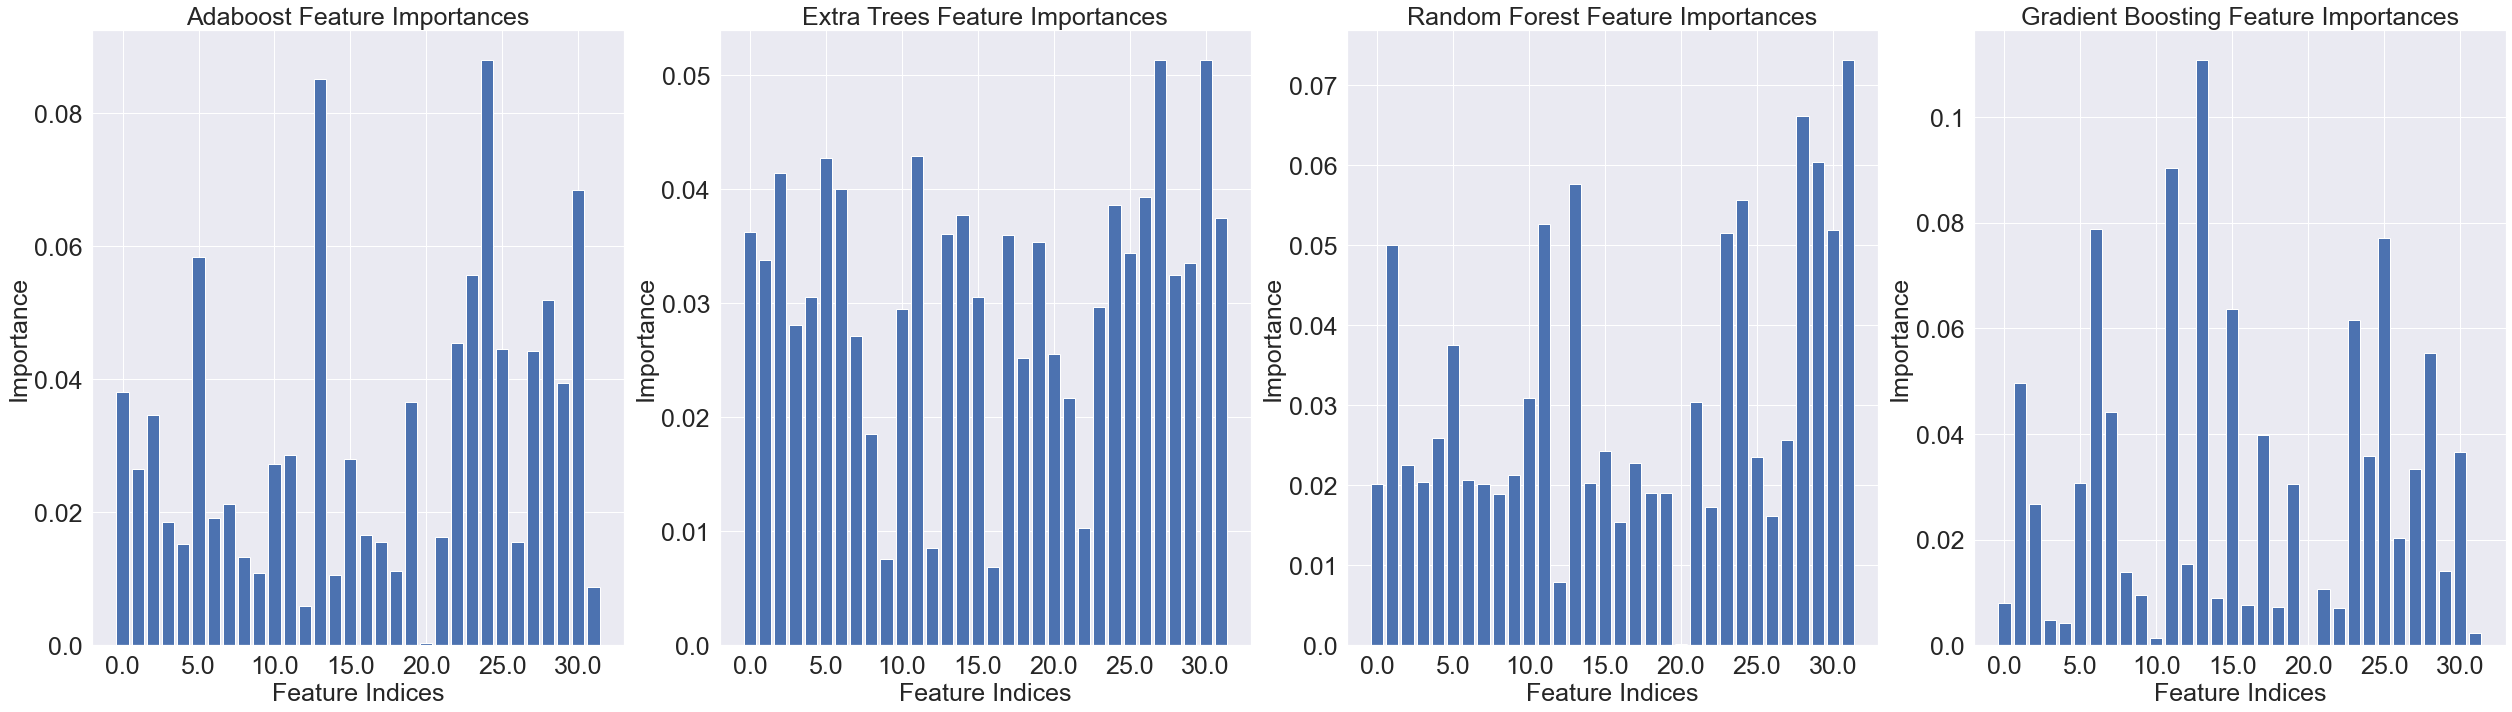

In [281]:
# Visualizes the feature importances
fig, axs = plt.subplots(1, 4, figsize=[35,10])
models = [adaboost, extra_trees, rf, grad_boost]
model_names = ['Adaboost', 'Extra Trees', 'Random Forest', 'Gradient Boosting']
for i, (model, model_name) in enumerate(zip(models, model_names)):
    axs[i].bar(np.arange(32), model.feature_importances_)
    axs[i].set_title(f'{model_name} Feature Importances', fontsize=25)
    axs[i].set_xlabel('Feature Indices', fontsize=25)
    axs[i].set_xticklabels(axs[i].get_xticks(), fontsize=25)
    axs[i].set_yticklabels(axs[i].get_yticks(), fontsize=25)
    axs[i].set_ylabel('Importance', fontsize=25)
    
plt.tight_layout()
plt.show()

In [282]:
# Make predictions on input training features
ada_pred = adaboost.predict(thought_vector)
bagg_pred = bagging.predict(thought_vector)
et_pred = extra_trees.predict(thought_vector)
rf_pred = rf.predict(thought_vector)
gb_pred = grad_boost.predict(thought_vector)

In [283]:
# Concatenate the first value of actual close normalize and all the values from ensemble models pred except last one
ada_actual = np.hstack([close_normalized[0], ada_pred[:-1]])
bagg_actual = np.hstack([close_normalized[0], bagg_pred[:-1]])
et_actual = np.hstack([close_normalized[0], et_pred[:-1]])
rf_actual = np.hstack([close_normalized[0], rf_pred[:-1]])
gb_actual = np.hstack([close_normalized[0], gb_pred[:-1]])
stacked_pred = np.vstack([ada_actual, bagg_actual, et_actual, rf_actual, gb_actual, close_normalized]).T

In [284]:
# Import XGB model 
import xgboost as xgb
param_xgb = {
    'max_depth': 7,
    'n_estimators': 10000,
    'learning_rate': 0.05,
    'objective': 'reg:logistic'
}


train_y = close_normalized[1:]
xgb_model = xgb.XGBRegressor(**param_xgb)
xgb_model.fit(stacked_pred[:-1, :], train_y, eval_set=[(stacked_pred[:-1, :], train_y)], # Features (input data) to be 
              # passed first, followed by the target variable (labels)
              
             eval_metric='rmse', early_stopping_rounds=20, verbose=False)



# Make predictions 
xgb_model_pred = xgb_model.predict(stacked_pred)
xgb_model_pred_actual = np.hstack([close_normalized[0], xgb_model_pred[:-1]])
date_ori = pd.to_datetime(data.iloc[:, 0]).tolist()
date = pd.Series(date_ori).dt.strftime(date_format='%y-%m-%d').tolist()



# Define a function that inverse transforms the close values to actual scale 
def reverse_close(array):
    return scaler.inverse_transform(array.reshape((-1,1))).reshape((-1))

### The XGB model is used to fit the stacked output of ensemble models predictions and the actual close price. Predictions are made by XGB model on stacked pred.

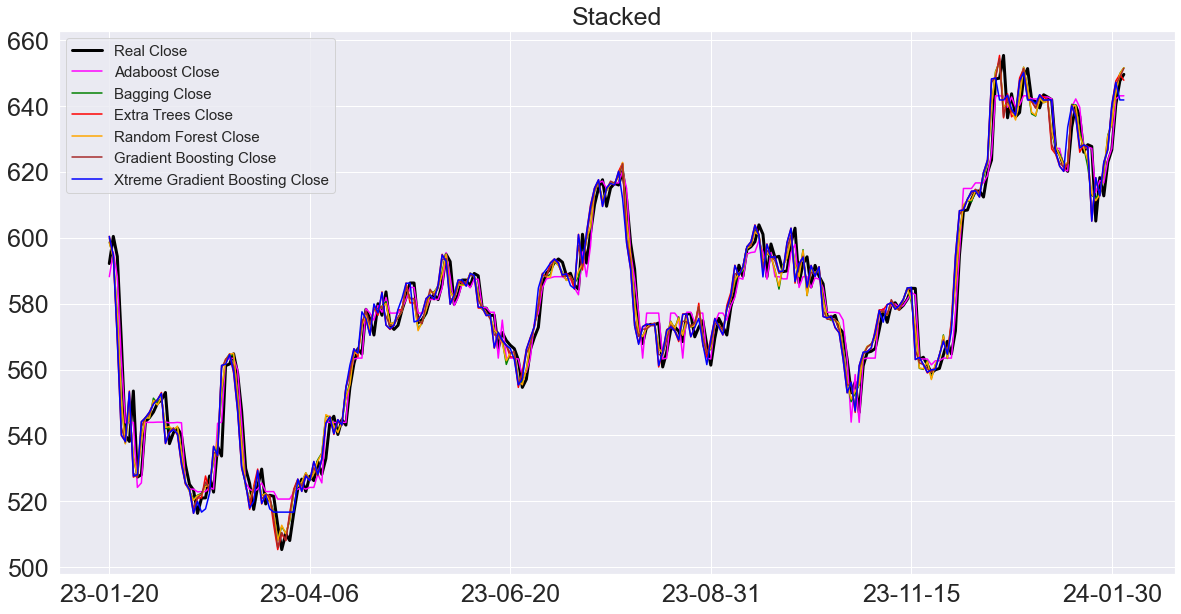

In [285]:
# Plot the graphs
plt.figure(figsize=[20,10])
x_range = np.arange(data['Close'].shape[0])

plt.plot(x_range, data['Close'], label='Real Close', color='black', linewidth=3)
plt.plot(x_range, reverse_close(ada_pred), label='Adaboost Close', color='magenta', linewidth=1.5)
plt.plot(x_range, reverse_close(bagg_pred), label='Bagging Close', color='green', linewidth=1.5)
plt.plot(x_range, reverse_close(et_pred), label='Extra Trees Close', color='red', linewidth=1.5)
plt.plot(x_range, reverse_close(rf_pred), label='Random Forest Close', color='orange', linewidth=1.5)
plt.plot(x_range, reverse_close(gb_pred), label='Gradient Boosting Close', color='brown', linewidth=1.5)
plt.plot(x_range, reverse_close(xgb_model_pred), label='Xtreme Gradient Boosting Close', color='blue', linewidth=1.5)

plt.legend(fontsize=15)
plt.xticks(x_range[::50], date[::50], fontsize=25)
plt.title('Stacked', fontsize=25)
plt.yticks(fontsize=25)
plt.show()

In [286]:
# Lets predict for future days 
ada_list = ada_pred.tolist()
bagging_list = bagg_pred.tolist()
et_list = et_pred.tolist()
rf_list = rf_pred.tolist()
gb_list = gb_pred.tolist()
xgb_list = xgb_model_pred.tolist()

# Define a function to forecast
def predict(iteration, future_days):
    for i in range(iteration):
        window = np.array(xgb_list[-future_days:])
        thought_vector = Encoder.encode(window.reshape((-1,1)))
    
# Make predictions for future days
        ada_pred = adaboost.predict(thought_vector)
        bagg_pred = bagging.predict(thought_vector)
        et_pred = extra_trees.predict(thought_vector)
        rf_pred = rf.predict(thought_vector)
        gb_pred = grad_boost.predict(thought_vector)
    
# Append last element from prediction to resp lists
        ada_list.append(ada_pred[-1])
        bagging_list.append(bagg_pred[-1])
        et_list.append(et_pred[-1])
        rf_list.append(rf_pred[-1])
        gb_list.append(gb_pred[-1])
    
# stack horizontally the last future days elements from xgb list and all the pred from ensemble models except last
        ada_actual = np.hstack([xgb_list[-future_days], ada_pred[:-1]])
        bagg_actual = np.hstack([xgb_list[-future_days], bagg_pred[:-1]])
        et_actual = np.hstack([xgb_list[-future_days], et_pred[:-1]])
        rf_actual = np.hstack([xgb_list[-future_days], rf_pred[:-1]])
        gb_actual = np.hstack([xgb_list[-future_days], gb_pred[:-1]])
    
# Stack all the predictions vertically
        stacked_prediction = np.vstack([ada_actual, bagg_actual, et_actual, rf_actual, gb_actual, xgb_list[-future_days:]]).T
    
# Make predictions on stacked_prediction using xgb model
        xgb_pred = xgb_model.predict(stacked_prediction)
        xgb_list.append(xgb_pred[-1])
        date_ori.append(date_ori[-1] + timedelta(days=1))
    
    
# Predict for future 5 days
predict(30, 5)

### All the predictions of ensemble models are converted to list. The function predict iterates over no of iterations to make predictions for future days. The rolling window is created with last 5 pred from xgb model. The input feature vector is created by encoding rolling window. The predictions are made on input vector. The last prediction from each ensemble model is appended to the resp lists. Last 5 predictions from XGB model and all the pred from ensemble models are stacked horizontally. Their results are stacked vertically to get 2D array stacked prediction. The prediction is made on this stacked result by XGB model. The model captures the days for which predictions are made.

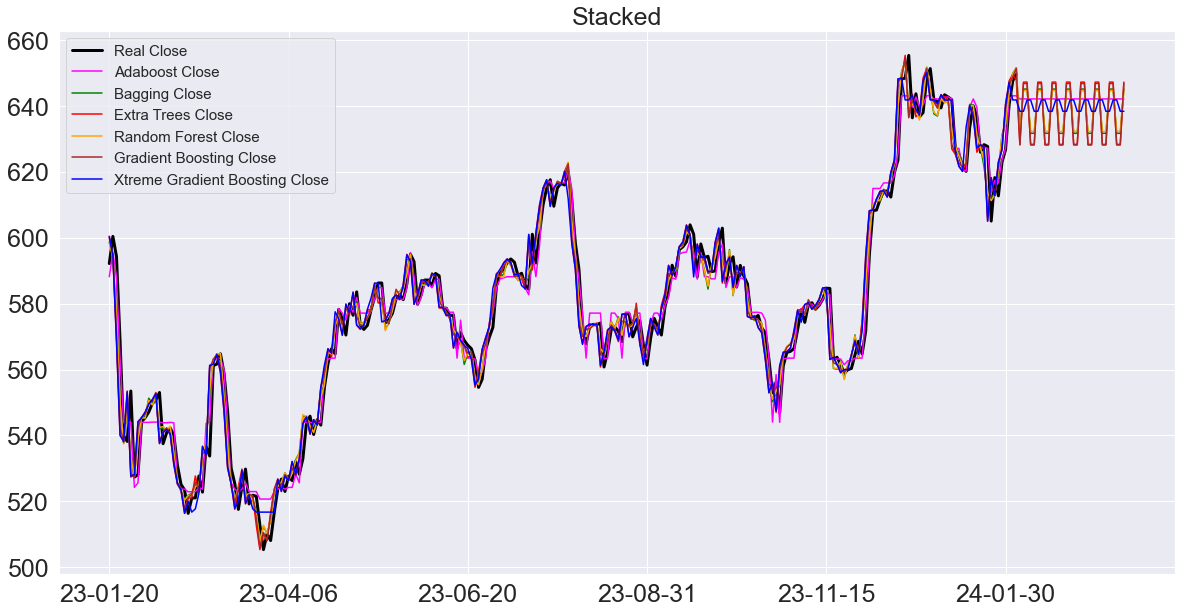

In [287]:
# Plot the result of each ensemble model
plt.figure(figsize=[20,10])
x_range = np.arange(data['Close'].shape[0])
x_range_future = np.arange(len(xgb_list))

plt.plot(x_range, data['Close'], label='Real Close', color='black', linewidth=3)
plt.plot(x_range_future, reverse_close(np.array(ada_list)), label='Adaboost Close', color='magenta', linewidth=1.5)
plt.plot(x_range_future, reverse_close(np.array(bagging_list)), label='Bagging Close', color='green', linewidth=1.5)
plt.plot(x_range_future, reverse_close(np.array(et_list)), label='Extra Trees Close', color='red', linewidth=1.5)
plt.plot(x_range_future, reverse_close(np.array(rf_list)), label='Random Forest Close', color='orange', linewidth=1.5)
plt.plot(x_range_future, reverse_close(np.array(gb_list)), label='Gradient Boosting Close', color='brown', linewidth=1.5)
plt.plot(x_range_future, reverse_close(np.array(xgb_list)), label='Xtreme Gradient Boosting Close', color='blue', linewidth=1.5)

plt.legend(fontsize=15)
plt.xticks(x_range[::50], date[::50], fontsize=25)
plt.title('Stacked', fontsize=25)
plt.yticks(fontsize=25)
plt.show()

In [288]:
from sklearn.metrics import mean_squared_error
true_values = close_normalized[1:] 

# Calculate MSE for each model

ada_mse = mean_squared_error(true_values, ada_pred[:-1])
bagging_mse = mean_squared_error(true_values, bagg_pred[:-1])
et_mse = mean_squared_error(true_values, et_pred[:-1])
gb_mse = mean_squared_error(true_values, gb_pred[:-1])
rf_mse = mean_squared_error(true_values, rf_pred[:-1])
xgb_mse = mean_squared_error(true_values, xgb_model_pred[:-1])

print("Mean Squared Error (MSE):")
print("AdaBoost:", ada_mse)
print("Bagging:", bagging_mse)
print("Extra Trees:", et_mse)
print("Gradient Boosting:", gb_mse)
print("Random Forest:", rf_mse)
print("XGBoost:", xgb_mse)
print()

Mean Squared Error (MSE):
AdaBoost: 0.002439317548487582
Bagging: 0.0005766927497764228
Extra Trees: 9.103879132491795e-05
Gradient Boosting: 0.00017047141168165968
Random Forest: 0.0005648679402778167
XGBoost: 0.00018225604490568594



### Extra Tree Model is performing better.

# 12) RNN-ARIMA-XGB

In [64]:
# Scaling the data using minmax scaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler().fit(data.iloc[:, 4].values.reshape((-1,1)))
df_ = scaler.fit_transform(data.iloc[:, 1:].astype('float32'))
df_ = pd.DataFrame(df_)
df_.head()

,0,1,2,3,4,5
0,0.572182,0.570229,0.620631,0.578807,0.533522,0.008078
1,0.603164,0.604839,0.635222,0.633789,0.584202,0.004925
2,0.636124,0.623992,0.635901,0.593135,0.546729,0.026611
3,0.585695,0.565188,0.461826,0.422193,0.389161,0.416620
4,0.402109,0.381720,0.223278,0.230590,0.212549,0.728968


In [65]:
import time
# Define a function autoencoder to reduce dimensions of inputs
def autoencoder(input_, dimensions=2, learning_rate=0.01, hidden_layer=256, epochs=20):
    
    tf.compat.v1.disable_eager_execution()

    input_size = input_.shape[1]
    X = tf.compat.v1.placeholder(tf.float32, [None, input_size])
    
    weights = {
        'encoder h1': tf.compat.v1.Variable(tf.compat.v1.random_normal([input_size, hidden_layer])),
        'encoder h2': tf.compat.v1.Variable(tf.compat.v1.random_normal([hidden_layer, dimensions])),
        'decoder h1': tf.compat.v1.Variable(tf.compat.v1.random_normal([dimensions, hidden_layer])),
        'decoder h2': tf.compat.v1.Variable(tf.compat.v1.random_normal([hidden_layer, input_size]))
    }
    
    biases = {
        'encoder b1': tf.compat.v1.Variable(tf.compat.v1.random_normal([hidden_layer])),
        'encoder b2': tf.compat.v1.Variable(tf.compat.v1.random_normal([dimensions])),
        'decoder b1': tf.compat.v1.Variable(tf.compat.v1.random_normal([hidden_layer])),
        'decoder b2': tf.compat.v1.Variable(tf.compat.v1.random_normal([input_size]))
    }
    
    first_layer_encoder = tf.compat.v1.nn.sigmoid(tf.add(tf.matmul(X, weights['encoder h1']), biases['encoder b1']))
    second_layer_encoder = tf.compat.v1.nn.sigmoid(tf.add(tf.matmul(first_layer_encoder, weights['encoder h2']), biases['encoder b2']))
    first_layer_decoder = tf.compat.v1.nn.sigmoid(tf.add(tf.matmul(second_layer_encoder, weights['decoder h1']), biases['decoder b1']))
    second_layer_decoder = tf.compat.v1.nn.sigmoid(tf.add(tf.matmul(first_layer_decoder, weights['decoder h2']), biases['decoder b2']))
    
    cost = tf.reduce_mean(tf.pow(X - second_layer_decoder, 2))
    optimizer = tf.compat.v1.train.RMSPropOptimizer(learning_rate).minimize(cost)
    sess = tf.compat.v1.InteractiveSession()
    sess.run(tf.compat.v1.global_variables_initializer())
    
    for i in range(epochs):
        start_time = time.perf_counter()
        grad, loss = sess.run([optimizer, cost], feed_dict={X: input_})
        end_time = time.perf_counter()
        if (i+1) % 10 == 0:
            print('epoch:', i+1, 'loss:', loss, 'time:', end_time - start_time)
            
    vector = sess.run(second_layer_encoder, feed_dict={X: input_})
    tf.compat.v1.reset_default_graph()
    return vector


thought_vector = autoencoder(df_.values, 4, 0.01, 128, 100)
thought_vector.shape

epoch: 10 loss: 0.17755452 time: 0.0015041999999994005
epoch: 20 loss: 0.1734053 time: 0.0012943000001541805
epoch: 30 loss: 0.1678575 time: 0.0012848000001213222
epoch: 40 loss: 0.1617638 time: 0.0013335000003280584
epoch: 50 loss: 0.15292288 time: 0.0013611000003947993
epoch: 60 loss: 0.1354009 time: 0.0012383000002955669
epoch: 70 loss: 0.13198061 time: 0.0013146999999662512
epoch: 80 loss: 0.13031702 time: 0.0012997999997423904
epoch: 90 loss: 0.12602364 time: 0.0012457999996513536
epoch: 100 loss: 0.11731044 time: 0.0013042000000496046


(254, 4)

In [66]:
# Create a class model with LSTM architecture
class Modell:
    def __init__(self, learning_rate, lstm_cells_no, lstm_layers_no, input_feature_size, output_size, forget_bias=0.1):
        
        def singlelayer_lstm(lstm_cells_no):
            return tf.compat.v1.nn.rnn_cell.LSTMCell(lstm_cells_no, state_is_tuple=False)
        
        multilayer_stacked = tf.compat.v1.nn.rnn_cell.MultiRNNCell([singlelayer_lstm(lstm_cells_no) for _ in range(lstm_layers_no)],
                                                                  state_is_tuple=False)
        
        self.X = tf.compat.v1.placeholder(tf.float32, (None, None, input_feature_size))
        self.y = tf.compat.v1.placeholder(tf.float32, (None, output_size))
        self.hidden_layer = tf.compat.v1.placeholder(tf.float32, (None, lstm_cells_no*lstm_layers_no*2))
        
        drop = tf.compat.v1.nn.rnn_cell.DropoutWrapper(multilayer_stacked, output_keep_prob=forget_bias)
        
        self.outputs, self.last_state = tf.compat.v1.nn.dynamic_rnn(drop, self.X, initial_state=self.hidden_layer, 
                                                                    dtype=tf.float32)
        
        rnn_w = tf.compat.v1.Variable(tf.compat.v1.random_normal([lstm_cells_no, output_size]))
        rnn_b = tf.compat.v1.Variable(tf.compat.v1.random_normal([output_size]))
        
        self.logits = tf.matmul(self.outputs[-1], rnn_w) + rnn_b
        self.cost = tf.reduce_mean(tf.square(self.y - self.logits))
        self.optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate).minimize(self.cost)

In [67]:
learning_rate = 0.01
lstm_cells_no = 128
lstm_layers_no = 1
input_feature_size = thought_vector.shape[1]
dropout_rate = 0.1
epoch = 500
timestamp = 5

# Initialize class Modell with actual parameters
tf.compat.v1.reset_default_graph()
modellstm = Modell(learning_rate, lstm_cells_no, lstm_layers_no, input_feature_size, 1, dropout_rate)
sess = tf.compat.v1.InteractiveSession()
sess.run(tf.compat.v1.global_variables_initializer())
for i in range(epoch):
    initial_hidden_state = np.zeros((1, lstm_cells_no*lstm_layers_no*2))
    total_loss = 0
    for k in range(0, (thought_vector.shape[0] // timestamp)*timestamp, timestamp):
        batch_X = np.expand_dims(thought_vector[k : k+timestamp, :], axis=0)
        batch_y = df_.values[k+1 : k+timestamp+1, 4].reshape([-1,1])
        
        last_hidden_state, grad, loss = sess.run([modellstm.last_state, modellstm.optimizer, modellstm.cost],
                                                feed_dict={modellstm.X: batch_X,
                                                          modellstm.y: batch_y,
                                                          modellstm.hidden_layer: initial_hidden_state})
        
        initial_hidden_state = last_hidden_state
        total_loss += loss
    total_loss /= (thought_vector.shape[0] // timestamp)
    if (i+1) % 100 == 0:
        print('epoch:', i+1, 'avg loss:', total_loss)

epoch: 100 avg loss: 0.018029927380848677
epoch: 200 avg loss: 0.01591002806322649
epoch: 300 avg loss: 0.014662359576905147
epoch: 400 avg loss: 0.015338715941179543
epoch: 500 avg loss: 0.014650692730210722


In [68]:
# Create an array to store output logits
output_pred = np.zeros(((thought_vector.shape[0] // timestamp)*timestamp, 1))
initial_hidden_state = np.zeros((1, lstm_cells_no*lstm_layers_no*2))
for k in range(0, (thought_vector.shape[0] // timestamp)*timestamp, timestamp):
    output_logits, last_hidden_state = sess.run([modellstm.logits, modellstm.last_state], feed_dict={
        modellstm.X: np.expand_dims(thought_vector[k: k+timestamp, :], axis=0),
        modellstm.hidden_layer: initial_hidden_state
    })
    
    initial_hidden_state = last_hidden_state
    output_pred[k: k+timestamp, :] = output_logits
    
    
print(np.mean(np.square(output_pred[:, 0] - df_.iloc[1: (thought_vector.shape[0] // timestamp)*timestamp + 1, 0].values)))

0.015335876917705889


In [70]:
# Build ARIMA architecture with parameters
import statsmodels.api as sm
from itertools import product
from scipy import stats

# Initialize the range of parameters
p = range(0, 2)  # Nonseasonal AR ele
q = range(0, 2)  # Nonseasonal MA ele
Ps = range(0, 2)  # Seasonal AR ele
Qs = range(0, 2)  # Seasonal MA ele
Ds = 1  # Seasonal differencing element

param = product(p, q, Ps, Qs)  # Possible Combinations Gridsearch
param_list = list(param)

# Initialize best AIC and best ARIMA
best_aic = float('inf')
best_arima = None
for i in param_list:
    arima = sm.tsa.statespace.SARIMAX(df_.iloc[:, 4].values, order=(i[0], Ds, i[1]), seasonal_order=(
            i[2], Ds, i[3], 7)).fit(disp=-1)
        
    aic = arima.aic
    if aic < best_aic:
        best_aic = aic
        best_arima = arima
        
print(best_aic)

# Check if best_arima is defined
if best_arima is not None:
    arima_pred = best_arima.predict()

C:\Users\asus\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\asus\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


-761.9585629494112


### Maximum Likelihood optimization, used in the fitting process of your ARIMA model, failed to converge. Despite the convergence warning, the model still produced an AIC value. The AIC is a measure of the relative quality of a statistical model for a given set of data. Lower AIC values indicate a better fit of the model to the data.

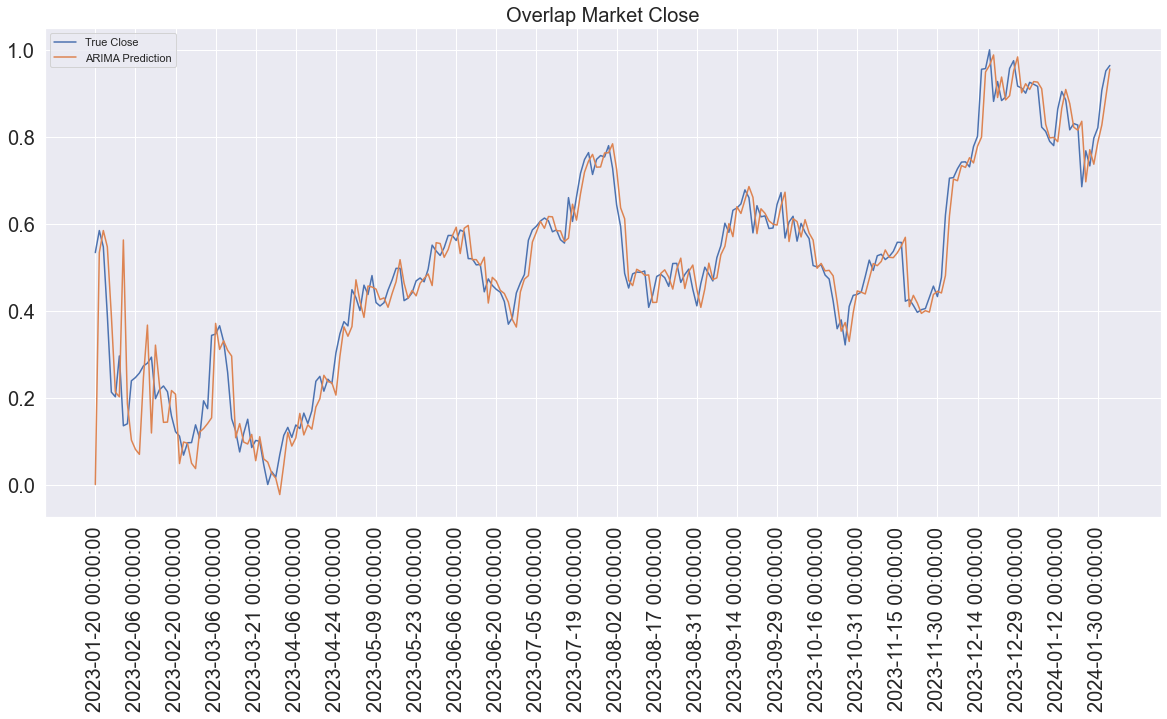

In [71]:
# Make predictions using arima
date_ori = pd.to_datetime(data.iloc[:, 0]).tolist()
x_range = np.arange(df_.shape[0])
plt.figure(figsize=[20,10])
axs = plt.subplot(111)
axs.plot(x_range, df_.iloc[:,4].values, label='True Close')
axs.plot(x_range, arima_pred, label='ARIMA Prediction')
box = axs.get_position()
axs.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])
plt.xticks(x_range[::10], date_ori[::10], rotation=90, fontsize=20)
plt.yticks(fontsize=20)
plt.title('Overlap Market Close', fontsize=20)
plt.legend()
plt.show()

In [72]:
# Build a vertical stack of predictions from arima and rnn
boundary = (thought_vector.shape[0] // timestamp)* timestamp
stacked_pred = np.vstack([arima_pred[:boundary], output_pred.reshape((-1))]).T

In [75]:
import xgboost as xgb
# Build an XGB model
params_xgb = {
    'max_depth': 7,
    'objective': 'reg:logistic',
    'learning_rate': 0.05,
    'n_estimators': 10000
    }

train_y = df_.values[:boundary, 4]
train_y_scaled = (train_y - train_y.min()) / (train_y.max() - train_y.min())

xgb_model = xgb.XGBRegressor(**params_xgb)
xgb_model.fit(stacked_pred, train_y_scaled, eval_set=[(stacked_pred, train_y_scaled)], 
        eval_metric='rmse', early_stopping_rounds=20, verbose=False)

# Make predictions
stacked = xgb_model.predict(stacked_pred)

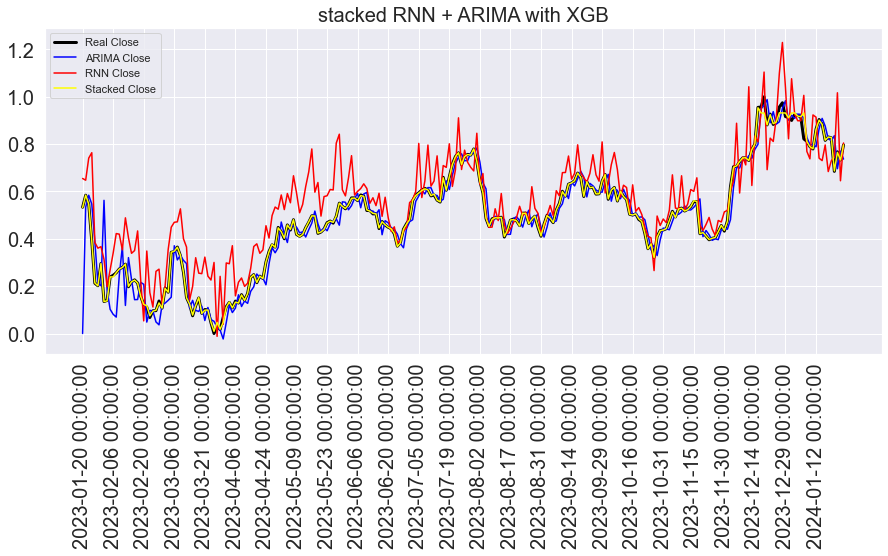

In [83]:
# Lets visualize the performances of models
plt.figure(figsize = (15,6))
x_range = np.arange(boundary)
plt.plot(x_range, (train_y), label = 'Real Close', color='black', linewidth=3)
plt.plot(x_range, (arima_pred[:boundary]), label = 'ARIMA Close', color='blue')
plt.plot(x_range, (output_pred), label = 'RNN Close', color='red')
plt.plot(x_range, (stacked), label = 'Stacked Close', color='yellow')
plt.legend()
plt.xticks(x_range[::10], date_ori[:boundary][::10], rotation=90, fontsize=20)
plt.yticks(fontsize=20)
plt.title('stacked RNN + ARIMA with XGB', fontsize=20)
plt.show()

In [85]:
from sklearn.metrics import mean_squared_error

true_value = train_y

# Calculate MSE for ARIMA model
mse_arima = mean_squared_error(true_value, arima_pred[:boundary])

# Calculate MSE for XGB model
mse_stacked = mean_squared_error(true_value, stacked)

# Calculate MSE for RNN model
mse_rnn = mean_squared_error(true_value, output_pred)

print("MSE for ARIMA:", mse_arima)
print("MSE for XGB:", mse_stacked)
print("MSE for RNN:", mse_rnn)

MSE for ARIMA: 0.004882705492251814
MSE for XGB: 9.019543e-05
MSE for RNN: 0.013587117676117316


### ARIMA is more important than RNN